###### demo_logsumexp.py

In [1]:
import os
from __future__ import print_function

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

plt.rcParams['figure.figsize'] = [5.0, 5.0]
# plt.rcParams['figure.dpi'] = 240

from subproblem_solvers import *
from logsumexp_coordinate_methods import *

import math
import scipy
from collections import defaultdict

from sklearn.datasets import load_svmlight_file
from functions import *
from algorithms import *
from loss_functions import *


from sys import platform as sys_pf
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TkAgg")

In [2]:
def plot_results(results, xparam, labels, 
                title, xlabel, figurename):
    
    plt.figure(figsize=(9, 11))
    
    linewidth = 2.5
    alpha = 1
    markeredgewidth=1.5
    markeredgecolor=[0,0,0,0.6]
    markevery= int(len(results[0][0]['grad'])/6)+1
    markers = ["<","s","p","D","X","v","P","^","o",">"]

    colors = sns.color_palette("colorblind")
    
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)

        
    for i,result in enumerate((results[0])):
        
        grad_mean = np.mean([results[j][i]['grad'] for j in range(rep)],axis=0)
        grad_std = np.std([results[j][i]['grad'] for j in range(rep)],axis=0)
            
        if xparam == 'time':
            time_mean = np.mean([results[j][i]['time'] for j in range(rep)],axis=0)
            
            plt.semilogy(time_mean, 
                         grad_mean, 
                         label=labels[i],
                         color=colors[i],
                         marker=markers[i],
                         markevery=markevery,
                         linewidth=linewidth,
                         alpha=alpha,
                         markeredgewidth=markeredgewidth,
                         markeredgecolor=markeredgecolor
                        )
            
        elif xparam is not None:
            plt.semilogy(result[xparam], 
                         grad_mean, 
                         label=labels[i],
                         color=colors[i],
                         marker=markers[i],
                         markevery=markevery,
                         linewidth=linewidth,
                         alpha=alpha,
                         markeredgewidth=markeredgewidth,
                         markeredgecolor=markeredgecolor
                        )
            plt.fill_between(result[xparam], grad_mean-grad_std, grad_mean+grad_std, 
                             color=colors[i], alpha=0.5)  
        else: 
            plt.semilogy(grad_mean, 
                         label=labels[i],
                         color=colors[i],
                         marker = markers[i],
                         markevery=markevery,
                         linewidth=linewidth,
                         alpha=alpha,
                         markeredgewidth=markeredgewidth,
                         markeredgecolor=markeredgecolor
                        )
            plt.fill_between(np.arange(0,len(grad_mean)), grad_mean-grad_std, grad_mean+grad_std, 
                             color=colors[i], alpha=0.3)
    
    if xparam is None:

        plt.semilogy(np.arange(1,len(grad_mean)),8*np.array(result['grad'])[0]*np.arange(1,len(grad_mean))**(-2/3), 'b--', \
             label = r'$\mathcal{O}(k^{-2/3})$')
    
    
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(r'$||\nabla f||$', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(fontsize=16,loc=(1,0))
    plt.tick_params(labelsize=14)
    
    if xparam is None:
        figure_name = 'plots/' + 'convergence_in_iterations_' + figurename + '.pdf' 
    else:
        figure_name = 'plots/' + 'convergence_in_' + xparam + '_' + figurename +'.pdf'
        
#     plt.savefig(figure_name, bbox_inches='tight')



In [3]:
def coordinate_cubic_newton_new(solver, loss, grad, hess_vec, hessian, X, Y, w_0, 
                                tolerance, tau=1,
                            max_iter=10000, H_0=1.0, line_search=True, 
                            trace=True, schedule='constant',scale_lin=1.0, scale_quad=1.0, c=1.0, exp=0.05, eps_1=1e-2, eps_2=1e-2, verbose_level=0):

    history = defaultdict(list) if trace else None
    start_timestamp = datetime.now()
    w_k = np.copy(w_0)
    H_k = H_0
    n = w_k.shape[0]
    num_coord_squared = 0 # total number of evaluated coordinates squared
    
    lambda_k = 0
    eta_1 = 0.1 # opt.get('success_treshold',0.1)
    eta_2 = 0.9 # opt.get('very_success_treshold',0.9)
    gamma_1 = 1.5 # opt.get('penalty_increase_multiplier',2.)
    gamma_2 = 2. # opt.get('penalty_derease_multiplier',2.)
    

    func_k = loss(w_k,X,Y)
    func_S_k = np.copy(func_k)
    
    

    # The whole gradient can be computed as:
    grad_k = grad(w_k, X, Y, np.arange(n))
    if schedule == 'adaptive':
        hessian_F = np.linalg.norm(hessian(w_k, X, Y, np.arange(n)),'fro')

    accepted_steps = 0
    for k in range(max_iter + 1):

        if np.linalg.norm(grad_k) <= tolerance:
            status = 'success'
            break

        if k == max_iter:
            status = 'iterations_exceeded'
            break

        # Choose randomly a subset of coordinates.
        if schedule == 'constant':
            tau_schedule = tau
        elif schedule == 'linear':
            tau_schedule = min(int(np.floor(tau+scale_lin*k)),len(w_0))
        elif schedule == 'quadratic':
            tau_schedule = min(int(np.floor(tau+scale_quad*k**2)),len(w_0))
        elif schedule == 'exponential':
            tau_schedule = min(int(np.floor(tau+c*np.exp(exp*k))),len(w_0))
        elif schedule == 'adaptive':
            print('term_1: ', 1-(eps_1**2/(np.linalg.norm(grad_k,2)**2)))
            print('term_2: ',np.sqrt(1 - eps_2/(hessian_F**2)))
            tau_schedule = min(int(len(w_0)*max(1-eps_1**2/(np.linalg.norm(grad_k,2)**2), 
                                            np.sqrt(1 - eps_2/(hessian_F**2)))),
                               len(w_0))
            print('tau(S_%d) = %d' %(k, tau_schedule))
        else:
            print('Unknown schedule type. Using constant coordinate schedule.')
            tau_schedule = tau
                    
        num_coord_squared += tau_schedule**2
        
        grad_k = grad(w_k, X, Y, np.arange(n)) # calculate full gradient to check convergence 
        
        if schedule == 'adaptive':
            hessian_F = np.linalg.norm(hessian(w_k, X, Y, np.arange(n)),'fro')# calculate the Frobenius norm for the adaptive schedule
            
        S = np.random.choice(n, tau_schedule, replace=False)
        X_S = X[:, S]
        
        grad_k_S = grad(w_k, X, Y, S)
        
        
        
        hess_v = lambda v: hess_vec(w_k, X, Y, S, v)
        hess = lambda w: hessian(w, X, Y, S)
        hess_k_S = hessian(w_k, X, Y, S)
        
        (h,lambda_k) = solve_ARC_subproblem(solver,
                                            grad_k_S, hess_v, hess_k_S,
                                            H_k, w_k[S],
                                            successful_flag=False,lambda_k=lambda_k,
                                            exact_tol=1e-10,krylov_tol=1e-1,solve_each_i_th_krylov_space=1, 
                                            keep_Q_matrix_in_memory=True)
    
        
        
        if trace:
            history['grad_S'].append(np.linalg.norm(grad_k_S))
            history['grad'].append(np.linalg.norm(grad_k))
            history['func_full'].append(func_k)
            history['func_S'].append(func_S_k)
            history['time'].append(
                (datetime.now() - start_timestamp).total_seconds())
            history['num_coord_squared'].append(num_coord_squared)
            history['H'].append(H_k)
        
        tmp_w_k = w_k.copy()
        tmp_w_k[S] += h
        
        func_T = loss(tmp_w_k,X,Y)
        func_S_T = loss(tmp_w_k[S],X_S,Y)

        #### III: Regularization Update #####

        function_decrease = func_k - func_T
        hn = np.linalg.norm(h)
        
        
        model_decrease= -(np.dot(grad_k_S, h) + 0.5 * np.dot(h, hess_v(h))+ 1/3*H_k*hn**3)
        

        
        rho = function_decrease / model_decrease
        assert (model_decrease >=0), 'negative model decrease. This should not have happened'

        
        # for debugging
        if verbose_level >= 1:
            print('model decr.: ', model_decrease)
            print('func decr. : ', function_decrease)
            print('rho: ', rho)
            print('norm(grd_k): ', np.linalg.norm(grad_k))
            print('norm(grad_k_S): ', np.linalg.norm(grad_k_S))
#               print('func_T: ', func_T)
            print('||h||: ', hn)
            print('norm(w_k): ', np.linalg.norm(tmp_w_k))
            print('H_k: ', H_k)
        
        
        # Update w if step s is successful
        if rho >= eta_1:
            accepted_steps += 1
            
            # Update the current point.
            w_k[S] += h
            func_k = func_T
            func_S_k = func_S_T
            successful_flag=True
        else:
            func_k=func_k  

        #Update penalty parameter
        if rho >= eta_2:
            H_k=max(H_k/gamma_2,1e-10)
            #alternative (Cartis et al. 2011): sigma= max(min(grad_norm,sigma),np.nextafter(0,1)) 
        
        elif rho < eta_1:
            H_k = gamma_1*H_k
            successful_flag=False   
#             print ('unscuccesful iteration')            

    return w_k, status, history

In [4]:
def do_experiment_logsumexp(loss, grad_x, hess_vec, hessian, solver,
                  rep, n, mu, lams, taus, schedule='constant', scales_lin=[1.0], scales_quad=[1.0], cs=[1.0], exps=[1.0],
                           figurename='', eps_1=1e-2, eps_2=1e-2):
    print('Experiment: \t n = %d, \t mu = %f.' % (n, mu))    
        
    results = []
    
    for i in range(rep):
        SSCN_results = []
        
        for lam in lams:
            for tau in taus:

                loss = lambda x, A, b: mu * logsumexp(1.0 / mu * (A.dot(x) - b)) + lam * np.sum(x**2/(1+x**2))

                def grad_x(x, A, b, S):
                    mu_inv = 1.0 / mu
                    Ax = A.dot(x)
                    a = mu_inv * (Ax - b)
                    pi = softmax(a)

                    return A[:,S].T.dot(pi) + 2*lam*x[S]/((1+x[S]**2)**2)

                def hess_vec(x, A, b, S, h):
                    mu_inv = 1.0 / mu
                    Ax = A.dot(x)
                    a = mu_inv * (Ax - b)
                    pi = softmax(a)

                    grad_S = grad_x(x, A, b, S)

                    return mu_inv * (A[:,S].T.dot(pi * A[:,S].dot(h)) - grad_S.dot(h) * grad_S) \
                                     + 2*lam * np.diag(( 1 - 3 * x[S]**2 )/( 1 + x[S]**2 )**3).dot(h) 

                def hessian(x, A, b, S):
                    mu_inv = 1.0 / mu
                    Ax = A.dot(x)
                    a = mu_inv * (Ax - b)
                    pi = softmax(a)

                    grad_S = grad_x(x, A, b, S)

                    hess = mu_inv * (A[:, S].T.dot(A[:, S] * pi.reshape(-1, 1)) \
                              - np.outer(grad_S, grad_S.T)) + 2*lam * np.diag(( 1 - 3 * x[S]**2 )/( 1 + x[S]**2 )**3) 

                    return hess

                start_timestamp = datetime.now()

                if schedule == 'exponential':
                    for exp in exps:
                        for c in cs:

                            w_k, status, history = \
                                coordinate_cubic_newton_new(solver, loss, grad_x, hess_vec, hessian, A, b, x_0, 
                                                    tolerance=tolerance, 
                                                    tau=tau,
                                                    max_iter=max_newton_iter,
                                                    H_0 = 1.0, line_search=True, 
                                                    c=c, exp=exp,
                                                    schedule=schedule)
                            t_secs = (datetime.now() - start_timestamp).total_seconds()
                            print(('SSCN with exponential schedule tau+c*e^(d*k) \t : lambda %.4f \t tau %d \t status \
                                   %s \t time %.4f \t c %.4f \t d %.4f'  % 
                                  (lam, tau, status, t_secs, c, exp)), flush=True)
                            SSCN_results.append(history)
                elif schedule == 'linear':
                    for scale in scales_lin:
                        w_k, status, history = \
                            coordinate_cubic_newton_new(solver, loss, grad_x, hess_vec, hessian, A, b, x_0, 
                                                    tolerance=tolerance, 
                                                    tau=tau,
                                                    max_iter=max_newton_iter,
                                                    H_0 = 1.0, line_search=True, 
                                                    scale_lin=scale,
                                                    schedule=schedule)
                        t_secs = (datetime.now() - start_timestamp).total_seconds()
                        print(('SSCN with linear schedule tau+s*k \t : lambda %.4f \t tau %d \t status \
                               %s \t time %.4f \t c %.4f'  % 
                              (lam, tau, status, t_secs, scale)), flush=True)
                        SSCN_results.append(history)
                elif schedule == 'quadratic':
                    for scale in scales_quad:
                        w_k, status, history = \
                            coordinate_cubic_newton_new(solver, loss, grad_x, hess_vec, hessian, A, b, x_0,
                                                    tolerance=tolerance, 
                                                    tau=tau,
                                                    max_iter=max_newton_iter,
                                                    H_0 = 1.0, line_search=True, 
                                                    scale_quad=scale, 
                                                    schedule=schedule)
                        t_secs = (datetime.now() - start_timestamp).total_seconds()
                        print(('SSCN with quadratic schedule tau+s*k^2 \t : lambda %.4f \t tau %d \t status \
                               %s \t time %.4f \t c %.4f'  % 
                              (lam, tau, status, t_secs, scale)), flush=True)
                        SSCN_results.append(history)
                elif schedule == 'adaptive':
                    w_k, status, history = \
                        coordinate_cubic_newton_new(solver, loss, grad_x, hess_vec, hessian, A, b, x_0,
                                                tolerance=tolerance, 
                                                tau=tau,
                                                max_iter=max_newton_iter,
                                                H_0 = 1.0, line_search=True,
                                                schedule=schedule,
                                                eps_1=eps_1, eps_2=eps_2)
                    t_secs = (datetime.now() - start_timestamp).total_seconds()
                    print(('SSCN with adaptive schedule'), flush=True)
                    SSCN_results.append(history)
                else:
                    w_k, status, history = \
                            coordinate_cubic_newton_new(solver, loss, grad_x, hess_vec, hessian, A, b, x_0,
                                                    tolerance=tolerance, 
                                                    tau=tau,
                                                    max_iter=max_newton_iter,
                                                    H_0 = 1.0, line_search=True, schedule=schedule)
                    t_secs = (datetime.now() - start_timestamp).total_seconds()
                    print(('SSCN with const schedule tau \t : lambda %.4f \t tau %d \t status \
                           %s \t time %.4f'  % 
                          (lam, tau, status, t_secs)), flush=True)
                    SSCN_results.append(history)
                    
        results.append(SSCN_results)
                        
    
#     colors = ['green','brown','gray','blue','black','yellow', 'orange', 'red','pink','purple','magenta']
#     linestyles = ['-', '--', '-.', ':'] * (int(len(taus) * len(lams) * len(scales_lin) * len(scales_quad) * len(exps) * len(cs)/4) + 1)
    
#     linewidths = [3] * len(taus) * len(lams) * len(scales_lin) * len(scales_quad) * len(exps) * len(cs)
#     alphas = [1] * len(taus) * len(lams) * len(scales_lin) * len(scales_quad) *len(exps) * len(cs)

#     folder = os.getcwd()+'/plots'
#     mu_str = ('%.2f' % mu)[2:]

    
    if schedule == 'constant':
        plot_results(results, None, [(r'$SSCN, \tau = %d$' % (tau)) 
                                                     for tau in taus 
                                                     ],
                 (r'$SSCN, n = %d, \sigma = %.2f$' % (n, mu)), 'Iterations $k$', figurename=figurename)
    elif schedule == 'linear':
        plot_results(results, None, [(r'SSCN, c_l= %.2f' % (scale)) 
                                                     for scale in scales_lin 
                                                     ],
                 (r'$SSCN, |S|=\tau + c k, n = %d, \sigma = %.2f, \tau = %d$' % (n, mu, tau)), 'Iterations $k$',figurename=figurename)
    elif schedule == 'exponential':
        plot_results(results, None, [(r'SSCN, c= %.2f, d = %.3f' % (c, exp)) 
                                                     for c in cs 
                                                     for exp in exps 
                                                     ],
                 (r'$SSCN, |S|=\tau + c \exp(d k), n = %d, \sigma = %.2f, \tau = %d$' % (n, mu, tau)), 'Iterations $k$', figurename=figurename)
    elif schedule == 'quadratic':
        plot_results(results, None, [(r'SSCN, c_q= %.5f' % (scale)) 
                                                     for scale in scales_quad 
                                                     ],
                 (r'$SSCN, |S|=\tau + c k^2, n = %d, \sigma = %.2f, \tau = %d$' % (n, mu, tau)), 'Iterations $k$', figurename=figurename)
        
    elif schedule == 'adaptive':
        plot_results(results, None, [(r'SSCN, adaptive')],
                 (r'$SSCN, n = %d, \sigma = %.2f, \tau = max(1- \frac{\epsilon_1^2}{\| \nabla f(x_k) \|^2}, \sqrt{1- \frac{\epsilon_2}{\|\nabla^2 f(x_k)\|^2_F}})$' % (n, mu)), 
                     'Iterations $k$', figurename=figurename)

    return w_k,results

In [5]:
def do_experiment_logisticloss_nonconvex(X, Y, w_0, loss, grad_x, hess_vec, hessian, solver,
                  rep, taus, schedule='constant', scales_lin=[1.0], scales_quad=[1.0], cs=[1.0], exps=[1.0],
                                        figurename=''):
    print('Logistic loss w/ non-convex regularization. \n Experiment: \t #dim = %d \t lam = %f' % (len(w_0), lam))    
        
    results = []
    
    for i in range(rep):
        SSCN_results = []
        
        for tau in taus:

            start_timestamp = datetime.now()

            if schedule == 'exponential':
                for exp in exps:
                    for c in cs:

                        w_k, status, history = \
                            coordinate_cubic_newton_new(solver, loss, grad_x, hess_vec, hessian, X, Y, w_0, 
                                                tolerance=tolerance, 
                                                tau=tau,
                                                max_iter=max_newton_iter,
                                                H_0 = 1.0, line_search=True, 
                                                c=c, exp=exp,
                                                schedule=schedule)
                        t_secs = (datetime.now() - start_timestamp).total_seconds()
                        print(('SSCN with exponential schedule tau+c*e^(d*k) \t : lambda %.4f \t tau %d \t status \
                               %s \t time %.4f \t c %.4f \t d %.4f'  % 
                              (lam, tau, status, t_secs, c, exp)), flush=True)
                        SSCN_results.append(history)
            elif schedule == 'linear':
                for scale in scales_lin:
                    w_k, status, history = \
                        coordinate_cubic_newton_new(solver, loss, grad_x, hess_vec, hessian, X, Y, w_0, 
                                                tolerance=tolerance, 
                                                tau=tau,
                                                max_iter=max_newton_iter,
                                                H_0 = 1.0, line_search=True, 
                                                scale_lin=scale,
                                                schedule=schedule)
                    t_secs = (datetime.now() - start_timestamp).total_seconds()
                    print(('SSCN with linear schedule tau+s*k \t : lambda %.4f \t tau %d \t status \
                           %s \t time %.4f \t c %.4f'  % 
                          (lam, tau, status, t_secs, scale)), flush=True)
                    SSCN_results.append(history)
            elif schedule == 'quadratic':
                for scale in scales_quad:
                    w_k, status, history = \
                        coordinate_cubic_newton_new(solver, loss, grad_x, hess_vec, hessian, X, Y, w_0,
                                                tolerance=tolerance, 
                                                tau=tau,
                                                max_iter=max_newton_iter,
                                                H_0 = 1.0, line_search=True, 
                                                scale_quad=scale, 
                                                schedule=schedule)
                    t_secs = (datetime.now() - start_timestamp).total_seconds()
                    print(('SSCN with quadratic schedule tau+s*k^2 \t : lambda %.4f \t tau %d \t status \
                           %s \t time %.4f \t c %.4f'  % 
                          (lam, tau, status, t_secs, scale)), flush=True)
                    SSCN_results.append(history)
            else:
                w_k, status, history = \
                        coordinate_cubic_newton_new(solver, loss, grad_x, hess_vec, hessian, X, Y, w_0,
                                                tolerance=tolerance, 
                                                tau=tau,
                                                max_iter=max_newton_iter,
                                                H_0 = 1.0, line_search=True, schedule=schedule)
                t_secs = (datetime.now() - start_timestamp).total_seconds()
                print(('SSCN with const schedule tau \t : lambda %.4f \t tau %d \t status \
                       %s \t time %.4f'  % 
                      (lam, tau, status, t_secs)), flush=True)
                SSCN_results.append(history)
                    
        results.append(SSCN_results)
                        

    print('')
    colors = ['green','brown','gray','blue','black','yellow', 'orange', 'red','pink','purple','magenta']
    linestyles = ['-', '--', '-.', ':'] * (int(len(taus) * len(scales_lin) * len(scales_quad) * len(exps) * len(cs)/4) + 1)
    
    linewidths = [3] * len(taus) * len(scales_lin) * len(scales_quad) * len(exps) * len(cs)
    alphas = [1] * len(taus) * len(scales_lin) * len(scales_quad) *len(exps) * len(cs)

    folder = os.getcwd()+'/plots'
#     mu_str = ('%.2f' % mu)[2:]

    
    if schedule == 'constant':
        plot_results(results, None, [(r'$SSCN, \tau = %d$' % (tau)) 
                                                     for tau in taus 
                                                     ],
                 (r'$SSCN, n = %d$' % (len(w_0))), 'Iterations $k$',figurename=figurename)
    elif schedule == 'linear':
        plot_results(results, None, [(r'SSCN, c_l= %.2f' % (scale)) 
                                                     for scale in scales_lin 
                                                     ],
                 (r'$SSCN, |S|=\tau + c k, n = %d, \tau = %d$' % (len(w_0), tau)), 'Iterations $k$',figurename=figurename)
    elif schedule == 'exponential':
        plot_results(results, None, [(r'SSCN, c= %.2f, d = %.3f' % (c, exp)) 
                                                     for c in cs 
                                                     for exp in exps 
                                                     ],
                 (r'$SSCN, |S|=\tau + c \exp(d k), n = %d, \tau = %d$' % (len(w_0), tau)), 'Iterations $k$',figurename=figurename)
    elif schedule == 'quadratic':
        plot_results(results, None, [(r'SSCN, c_q= %.5f' % (scale)) 
                                                     for scale in scales_quad 
                                                     ],
                 (r'$SSCN, |S|=\tau + c k^2, n = %d, \tau = %d$' % (len(w_0), tau)), 'Iterations $k$',figurename=figurename)

    return results

In [6]:
# logsumexp Experiment: Defining loss, gradient, Hessian-vector product and Hessian
loss = lambda x, A, b, lam, mu: mu * logsumexp(1.0 / mu * (A.dot(x) - b)) + lam * np.sum(x**2/(1+x**2))

def grad_x(x, A, b, S, lam, mu):
    mu_inv = 1.0 / mu
    Ax = A.dot(x)
    a = mu_inv * (Ax - b)
    pi = softmax(a)

    return A[:,S].T.dot(pi) + 2*lam*x[S]/((1+x[S]**2)**2)

def hess_vec(x, A, b, S, h, lam, mu):
    mu_inv = 1.0 / mu
    Ax = A.dot(x)
    a = mu_inv * (Ax - b)
    pi = softmax(a)

    grad_S = grad_x(x, A, b, S, lam, mu)

    return mu_inv * (A[:,S].T.dot(pi * A[:,S].dot(h)) - grad_S.dot(h) * grad_S) \
                     + 2*lam * np.diag(( 1 - 3 * x[S]**2 )/( 1 + x[S]**2 )**3).dot(h) 

def hessian(x, A, b, S, lam, mu):
    mu_inv = 1.0 / mu
    Ax = A.dot(x)
    a = mu_inv * (Ax - b)
    pi = softmax(a)

    grad_S = grad_x(x, A, b, S, lam, mu)

    hess = mu_inv * (A[:, S].T.dot(A[:, S] * pi.reshape(-1, 1)) \
              - np.outer(grad_S, grad_S.T)) + 2*lam * np.diag(( 1 - 3 * x[S]**2 )/( 1 + x[S]**2 )**3) 

    return hess

Experiment: 	 n = 200, 	 mu = 0.100000.
term_1:  0.9854310971900598
term_2:  0.5550146831465035
tau(S_0) = 197
term_1:  0.9854310971900598
term_2:  0.5550146831465035
tau(S_1) = 197
term_1:  0.987071963638018
term_2:  0.9252621003288592
tau(S_2) = 197
term_1:  0.9765328180872316
term_2:  0.9999942376480161
tau(S_3) = 199
term_1:  0.9774771526487459
term_2:  0.9999950098280851
tau(S_4) = 199
term_1:  0.9834875257037481
term_2:  0.999599222880097
tau(S_5) = 199
term_1:  0.9834875257037481
term_2:  0.999599222880097
tau(S_6) = 199
term_1:  0.9724941061607857
term_2:  0.9999971474514375
tau(S_7) = 199
term_1:  0.9847660150310541
term_2:  0.6201738434187112
tau(S_8) = 196
term_1:  0.9847660150310541
term_2:  0.6201738434187112
tau(S_9) = 196
term_1:  0.9847660150310541
term_2:  0.6201738434187112
tau(S_10) = 196
term_1:  0.9847660150310541
term_2:  0.6201738434187112
tau(S_11) = 196
term_1:  0.9842260076143614
term_2:  0.9999314410499125
tau(S_12) = 199
term_1:  0.9668178263039184
term_2:  

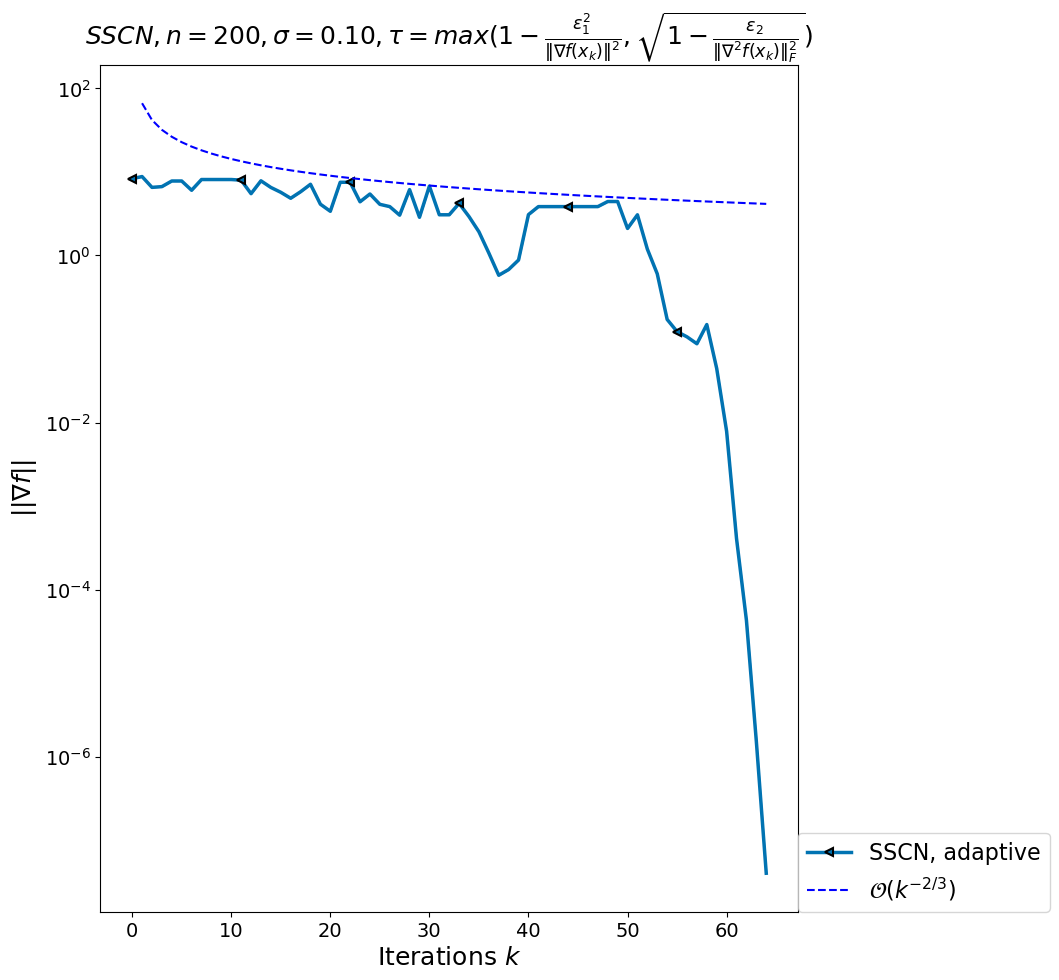

In [441]:
# Adaptive schedule
n=200
mu=0.1
(A, b, mu, x_star, f_star) = generate_logsumexp(n=n, mu=mu)
x_0 = np.ones(n)

rep = 1
seed = 31415

np.random.seed(seed)

tolerance = 1e-7
max_newton_iter = 1000
solver = 'exact'

lams = [1e-3]
taus = [10]


_, SSCN_logsumexp_n50_adaptive = do_experiment_logsumexp(loss, grad_x, hess_vec, hessian, solver,
                  rep, n, mu, lams, taus, schedule='adaptive', figurename='logsumexp_n=%d_lam=%.3f_adaptive' % (n,lams[0]),
                  eps_1=1,eps_2=0.5)

Experiment: 	 n = 200, 	 mu = 0.100000.
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 10 	 status                            iterations_exceeded 	 time 2.7011
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 50 	 status                            iterations_exceeded 	 time 6.9917
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 100 	 status                            iterations_exceeded 	 time 13.6996


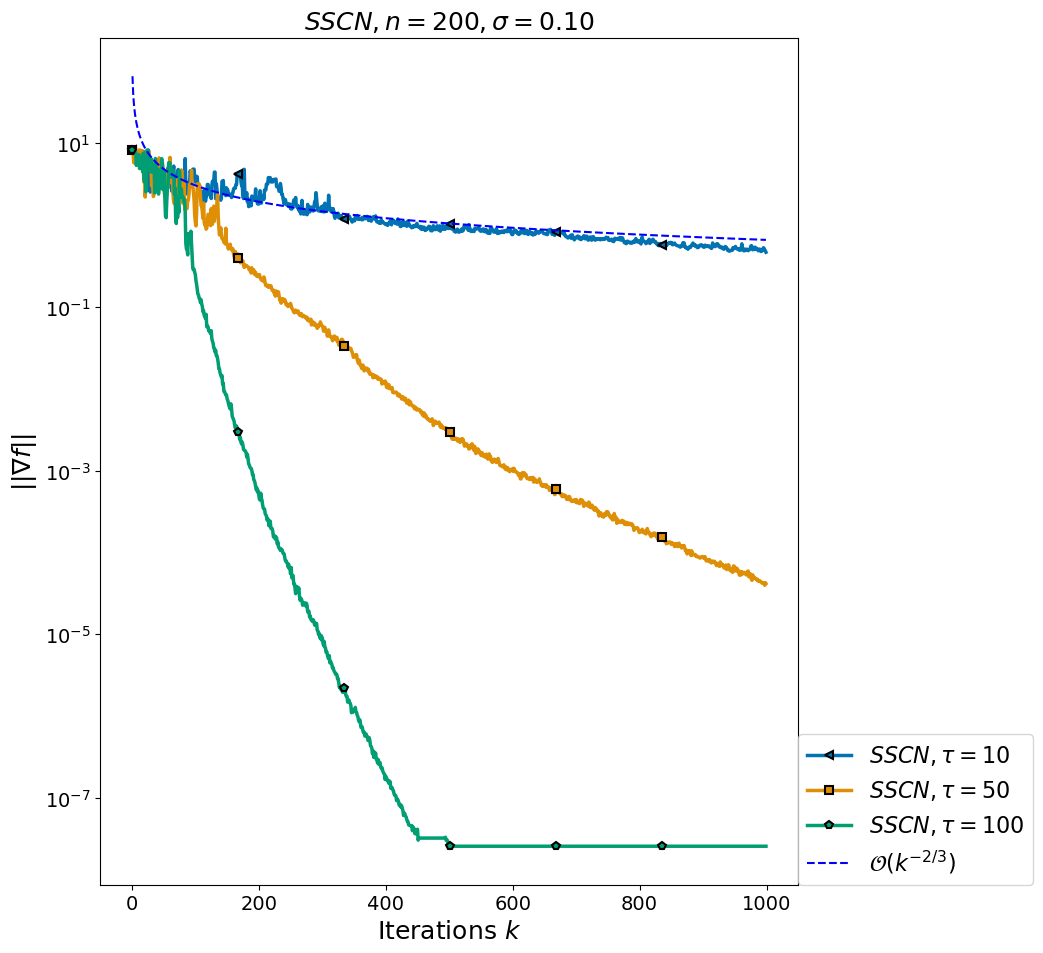

In [10]:
# Constant schedule, n=100
n=200
mu=0.1
(A, b, mu, x_star, f_star) = generate_logsumexp(n=n, mu=mu)
x_0 = np.ones(n)

rep = 1
seed = 31415

np.random.seed(seed)

tolerance = 1e-15
max_newton_iter = 1000
solver = 'exact'

lams = [1e-3]
# taus = [10,50,100,200,400,500]
taus = [10,50,100]


_, SSCN_logsumexp_const_schedule_n100_cauchy_pt = do_experiment_logsumexp(loss, grad_x, hess_vec, hessian, solver,
                  rep, n, mu, lams, taus, schedule='constant', scales_lin=[1.0], scales_quad=[1.0], cs=[1.0], exps=[1.0],
                                                               figurename='logsumexp_n=%d_lam=%.3f_exact' % (n,lams[0]))

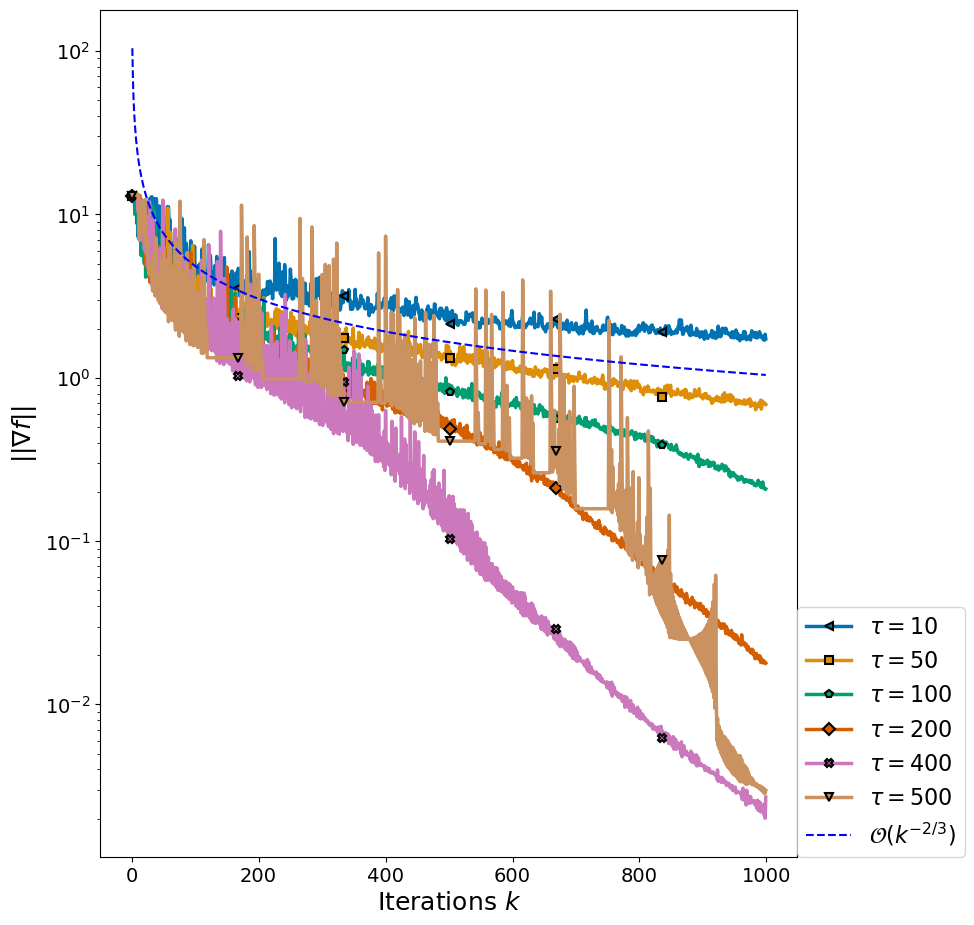

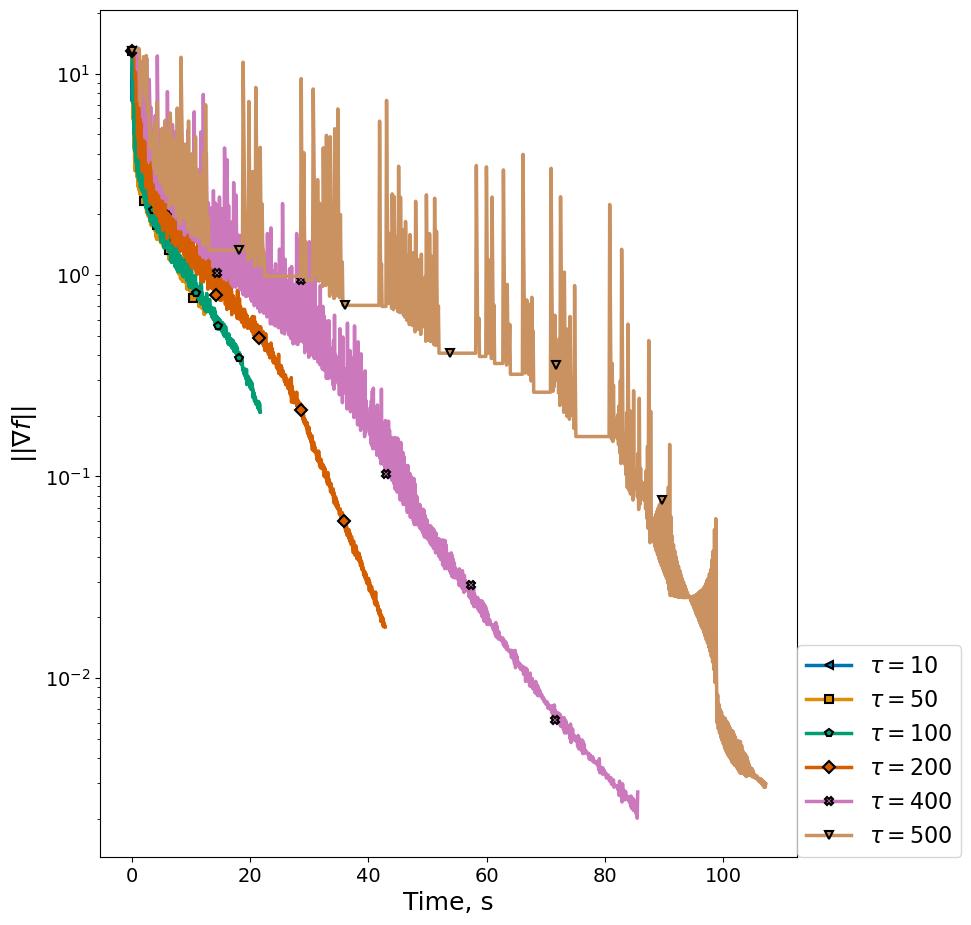

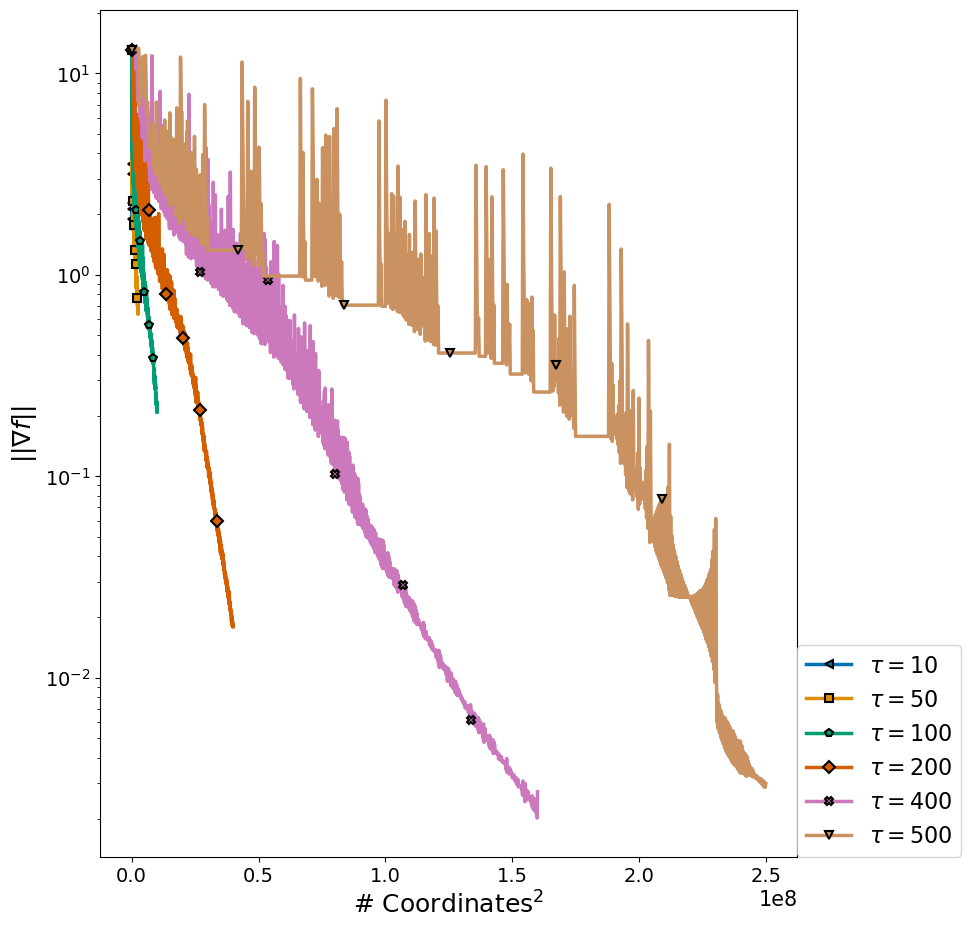

In [426]:
# logsumexp Experiment: n=100, Plotting results

taus = [10,50,100,200,400,500]

plot_results(SSCN_logsumexp_const_schedule_n100_cauchy_pt, None, [(r'$\tau = %d$' % (tau)) 
                                                     for tau in taus 
                                                     ],
                 '', 'Iterations $k$',figurename ='logsumexp_n=%d_lam=%.3f_cauchy_pt' % (n,lams[0]) )

plot_results(SSCN_logsumexp_const_schedule_n100_cauchy_pt, 'time', [(r'$\tau = %d$' % (tau)) 
                                                     for tau in taus 
                                                     ],
                 '' , 'Time, s', figurename ='logsumexp_n=%d_lam=%.3f_cauchy_pt' % (n,lams[0]))

plot_results(SSCN_logsumexp_const_schedule_n100_cauchy_pt, 'num_coord_squared', 
             [(r'$\tau = %d$' % (tau))for tau in taus],
             '', '# Coordinates$^2$', figurename ='logsumexp_n=%d_lam=%.3f_cauchy_pt' % (n,lams[0]))

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 10 	 status                            iterations_exceeded 	 time 7.5550
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 50 	 status                            iterations_exceeded 	 time 14.5380
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 100 	 status                            iterations_exceeded 	 time 28.9280
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 200 	 status                            iterations_exceeded 	 time 72.0689
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 500 	 status                            iterations_exceeded 	 time 299.6182
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 10 	 status                            iterations_exceeded 	 time 7.6494
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 50 	 status                            iterations_exceeded 	 time 14.5126
SSCN with const schedule tau 	 : lambda 0.0010 	 tau 100 	 status    

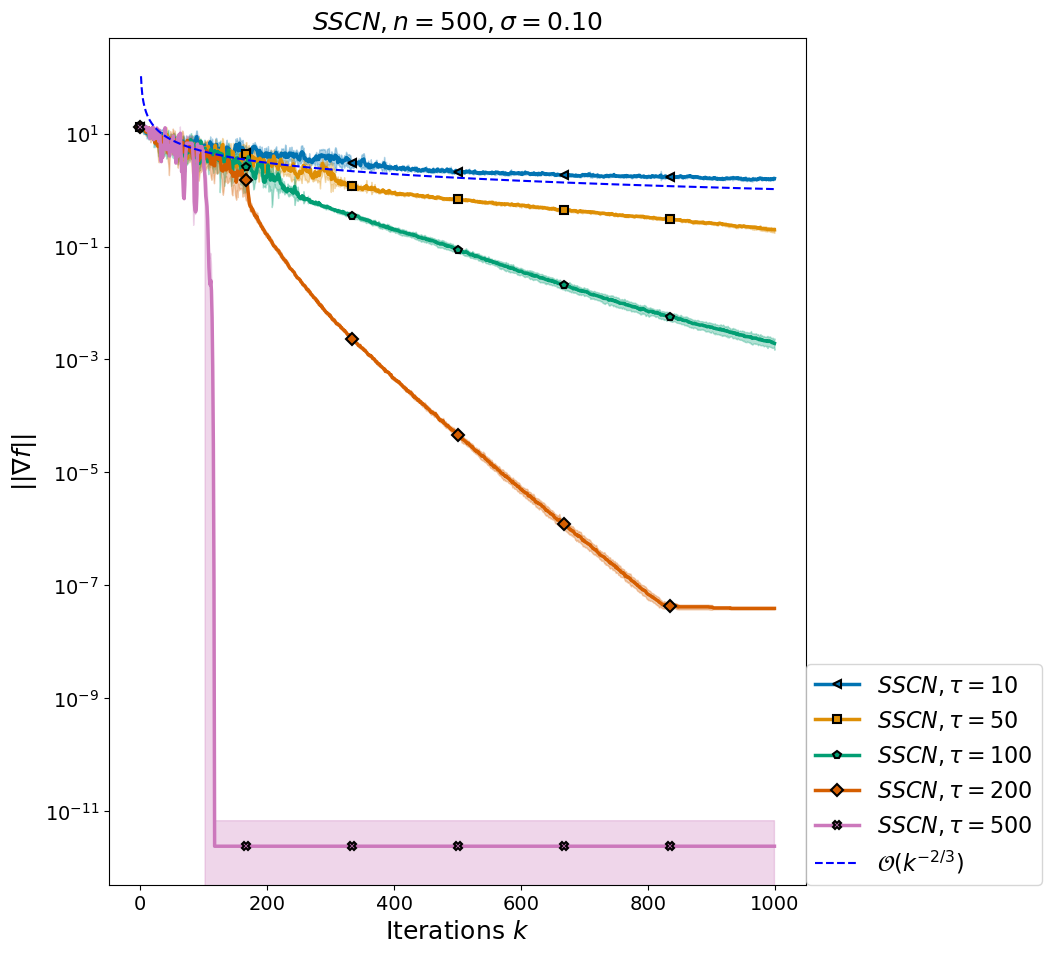

In [333]:
# Creating dataset
n = 500
mu = 0.1
(A, b, mu, x_star, f_star) = generate_logsumexp(n=n, mu=mu)
x_0 = np.ones(n)

rep = 5
seed = 31415

np.random.seed(seed)

tolerance = 1e-15
max_newton_iter = 1000
solver = 'exact'

lams = [1e-3]
taus = [10,50,100,200,500]


_, SSCN_logsumexp_const_schedule_n500 = do_experiment_logsumexp(loss, grad_x, hess_vec, hessian, solver,
                  rep, n, mu, lams, taus, schedule='constant', scales_lin=[1.0], scales_quad=[1.0], cs=[1.0], exps=[1.0],
                                                               figurename='logsumexp_n=%d_lam=%.3f' % (n,lams[0]))

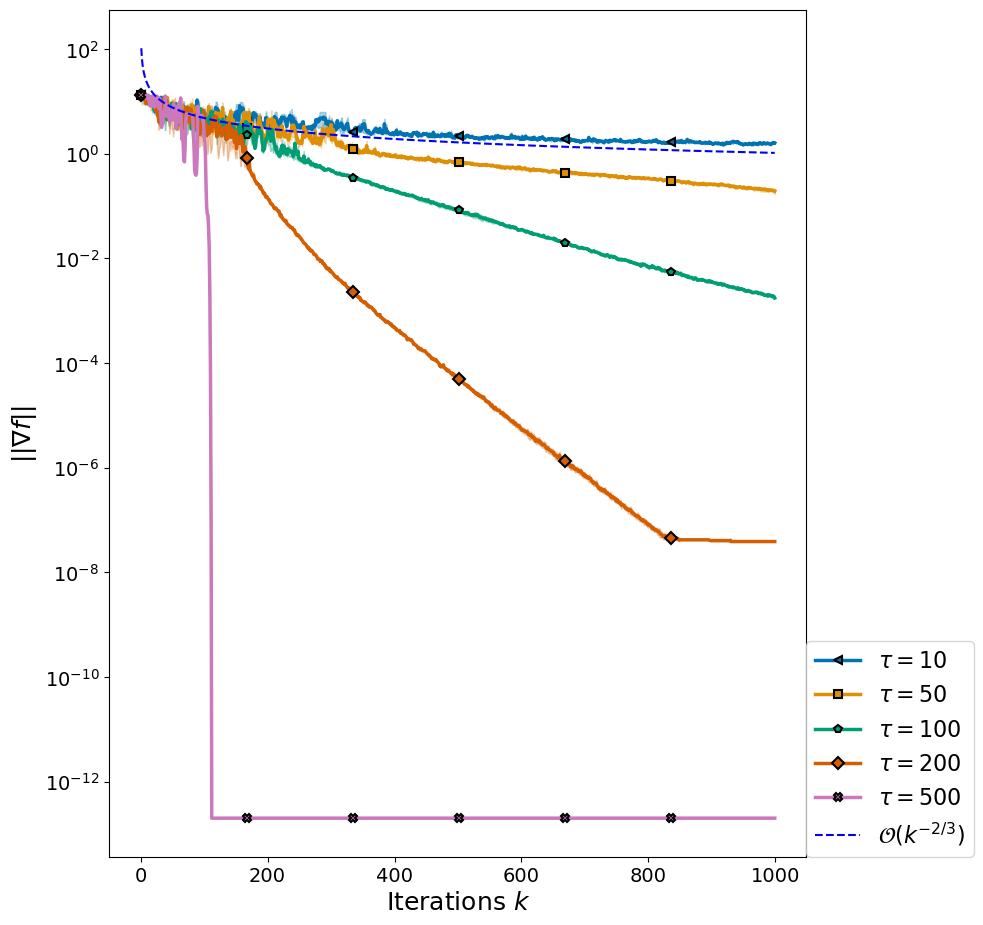

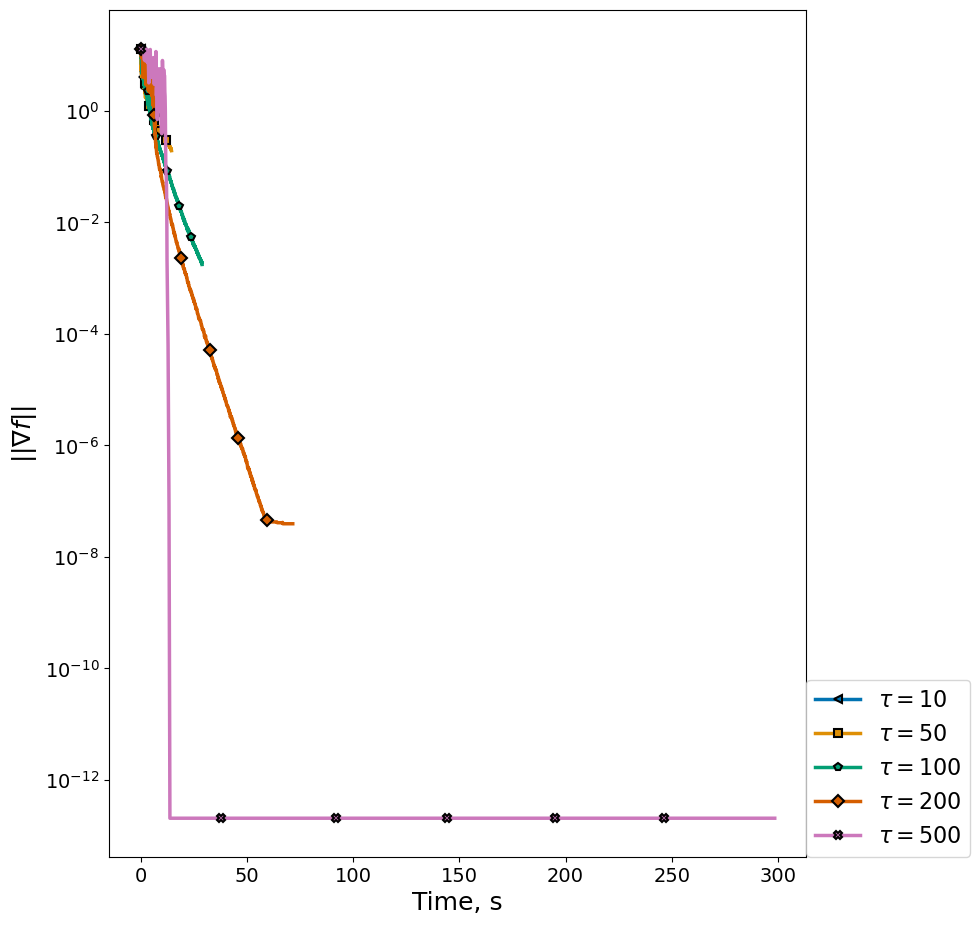

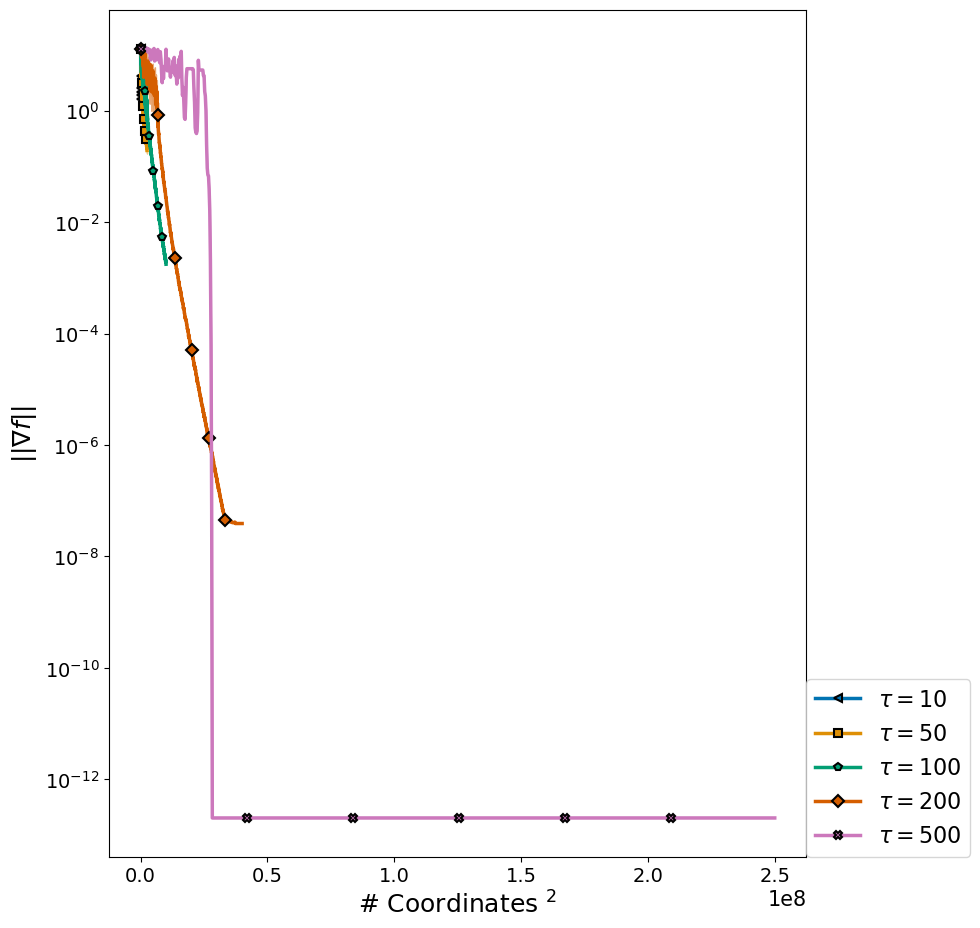

In [399]:
# logsumexp Experiment: n=500, Plotting results

taus = [10,50,100,200,500]

plot_results(SSCN_logsumexp_const_schedule_n500, None, [(r'$\tau = %d$' % (tau)) 
                                                     for tau in taus 
                                                     ],
                 '', 'Iterations $k$', figurename ='logsumexp_n=%d_lam=%.3f' % (n,lams[0]))

plot_results(SSCN_logsumexp_const_schedule_n500, 'time', [(r'$\tau = %d$' % (tau)) 
                                                     for tau in taus 
                                                     ],
                 '' , 'Time, s', figurename ='logsumexp_n=%d_lam=%.3f' % (n,lams[0]))

plot_results(SSCN_logsumexp_const_schedule_n500, 'num_coord_squared', 
             [(r'$\tau = %d$' % (tau))for tau in taus],
             '', r'# Coordinates $^2$', figurename ='logsumexp_n=%d_lam=%.3f' % (n,lams[0]))

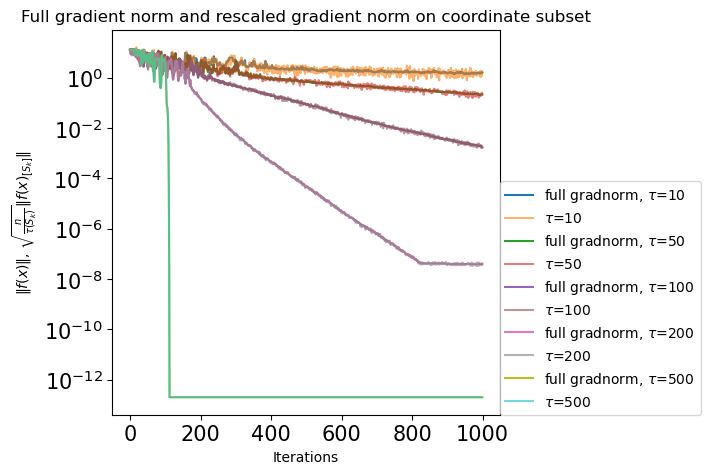

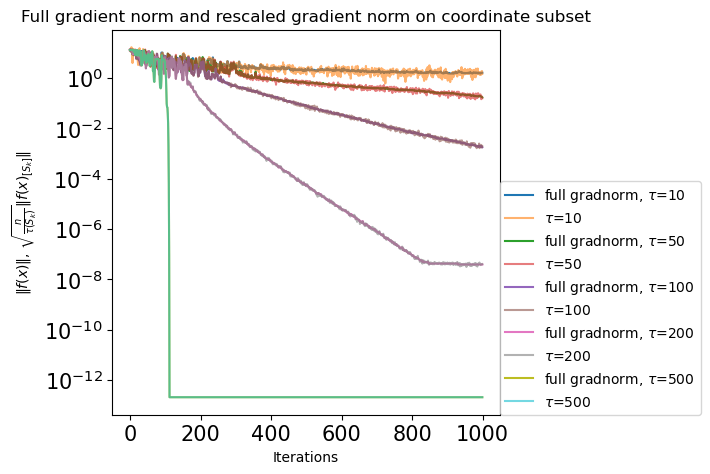

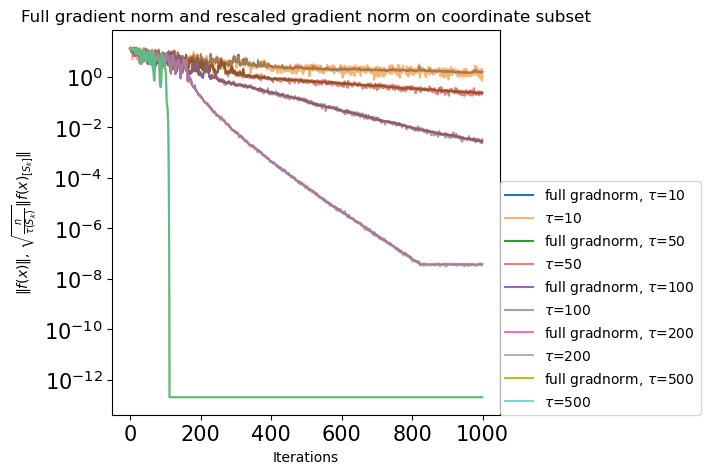

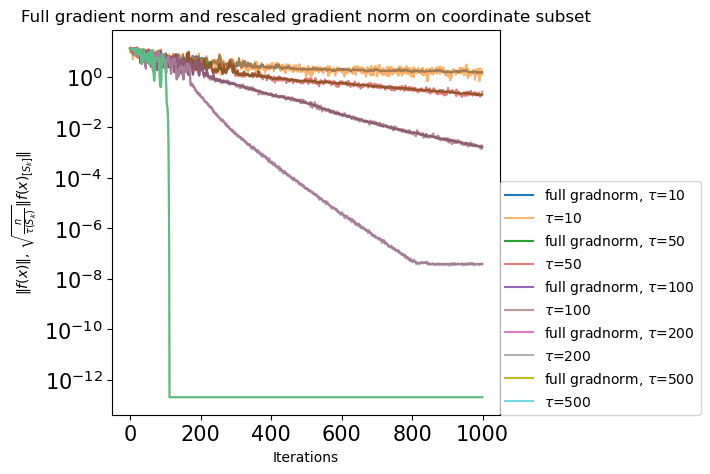

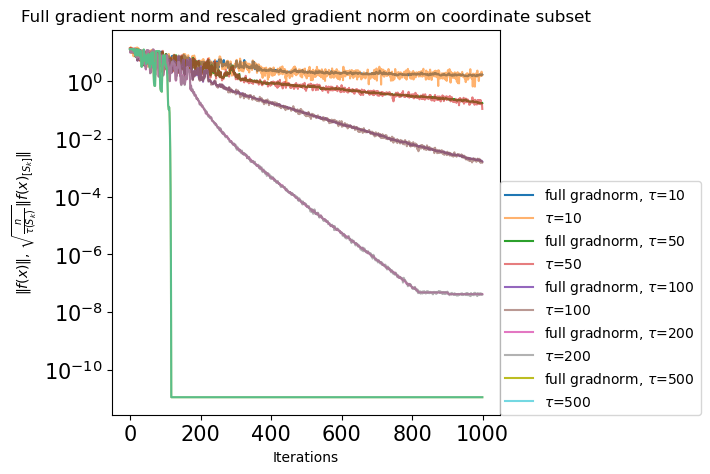

In [340]:
iterations = 1000
taus = [10,50,100,200,500]

for j in range(len(SSCN_logsumexp_const_schedule_n500)):
    plt.figure(figsize=(5,5))
    for i in range(len(SSCN_logsumexp_const_schedule_n500)):
        grad = SSCN_logsumexp_const_schedule_n500[j][i]['grad']
        grad_S = SSCN_logsumexp_const_schedule_n500[j][i]['grad_S']

    # grad1 = SSCN_logsumexp_const_schedule_n200[1][3]['grad']
    # grad_S1 = SSCN_logsumexp_const_schedule_n200[1][3]['grad_S']

        plt.semilogy(grad, label=r'full gradnorm, $\tau$=%d' %taus[i], alpha=1)
        plt.semilogy(np.sqrt(taus[-1]/taus[i])*np.array(grad_S), label=r'$\tau$=%d' %taus[i], alpha=0.6)

    # plt.plot(np.array(grad)/np.array(grad_S))
    # plt.semilogy(grad1, label='grad1')
    # plt.semilogy(grad_S1, label='grad_S1')
    plt.legend(loc=(1,0))
    plt.xlabel('Iterations')
    plt.ylabel(r'$\|f(x)\|$, $\sqrt{\frac{n}{\tau(S_k)}} \|f(x)_{[S_k]}\|$')
    plt.title('Full gradient norm and rescaled gradient norm on coordinate subset')
    
    plt.savefig('plots/full_gradient_norm_and_rescaled_coordinate_gradient_norm_const_schedule.pdf', bbox_inches='tight')

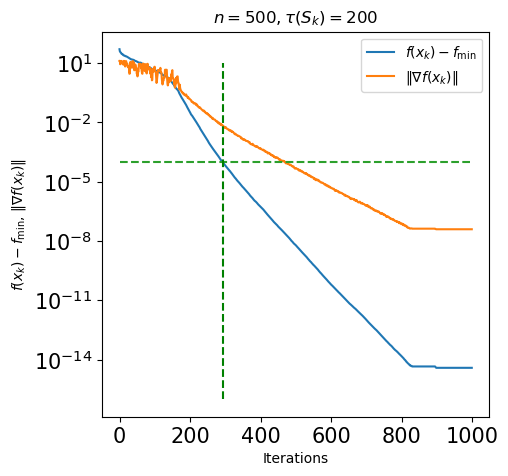

In [385]:
epsilon = 1e-16
plt.semilogy(np.array(SSCN_logsumexp_const_schedule_n500[0][-2]['func_full'])-f_star+epsilon, label=r'$f(x_k)-f_{\min}$')
plt.semilogy(np.array(SSCN_logsumexp_const_schedule_n500[0][-2]['grad']), label=r'$\|\nabla f(x_k)\|$')

plt.semilogy(np.arange(0,1000),1e-4*np.ones((1000)),'--')

plt.vlines(293,epsilon,10, 'green',linestyles='--')

plt.xlabel('Iterations')
plt.ylabel(r'$f(x_k)-f_{\min}$, $\|\nabla f(x_k)\|$')
plt.legend()
plt.title(r'$n=500, \tau(S_k)=200$')

plt.savefig('plots/residual_vs_grad_norm.pdf', bbox_inches='tight')

In [376]:
(np.array(SSCN_logsumexp_const_schedule_n500[0][-2]['func_full'])-f_star+epsilon)[293]

np.array(SSCN_logsumexp_const_schedule_n500[0][-2]['grad'])[293]

0.006622041518164693

In [400]:
# Creating dataset
n = 500
mu = 0.1
(A, b, mu, x_star, f_star) = generate_logsumexp(n=n, mu=mu)
x_0 = np.ones(n)

rep = 5
seed = 31415

np.random.seed(seed)

tolerance = 1e-15
max_newton_iter = 1000
solver = 'exact'

lams = [1e-3]
taus = [30]


# linear coordinate schedule
_, SSCN_logsumexp_n500_lin = do_experiment_logsumexp(loss, grad_x, hess_vec, hessian, solver,
                  rep, n, mu, lams, taus, schedule='linear', scales_lin=[0.1,0.5,1.0],
                                                               figurename='logsumexp_n=%d_lam=%.3f_linear' % (n,lams[0]))

Experiment: 	 n = 500, 	 mu = 0.100000.


KeyboardInterrupt: 

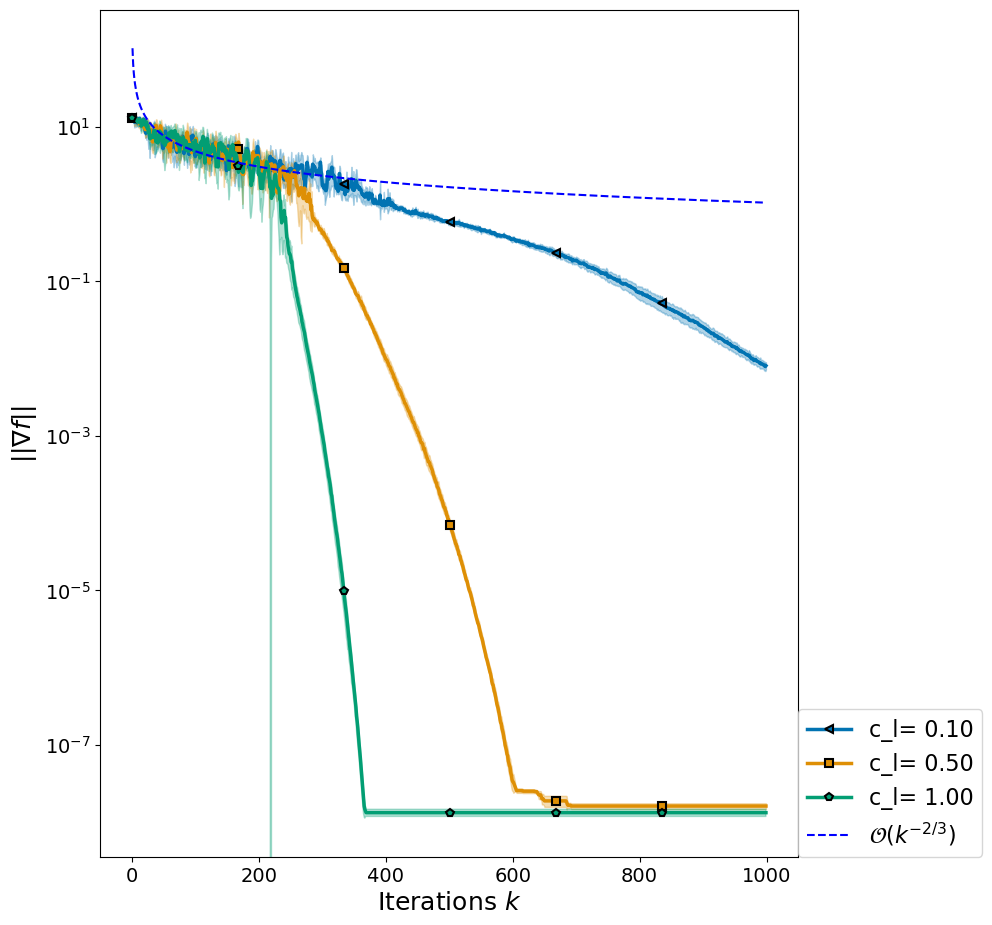

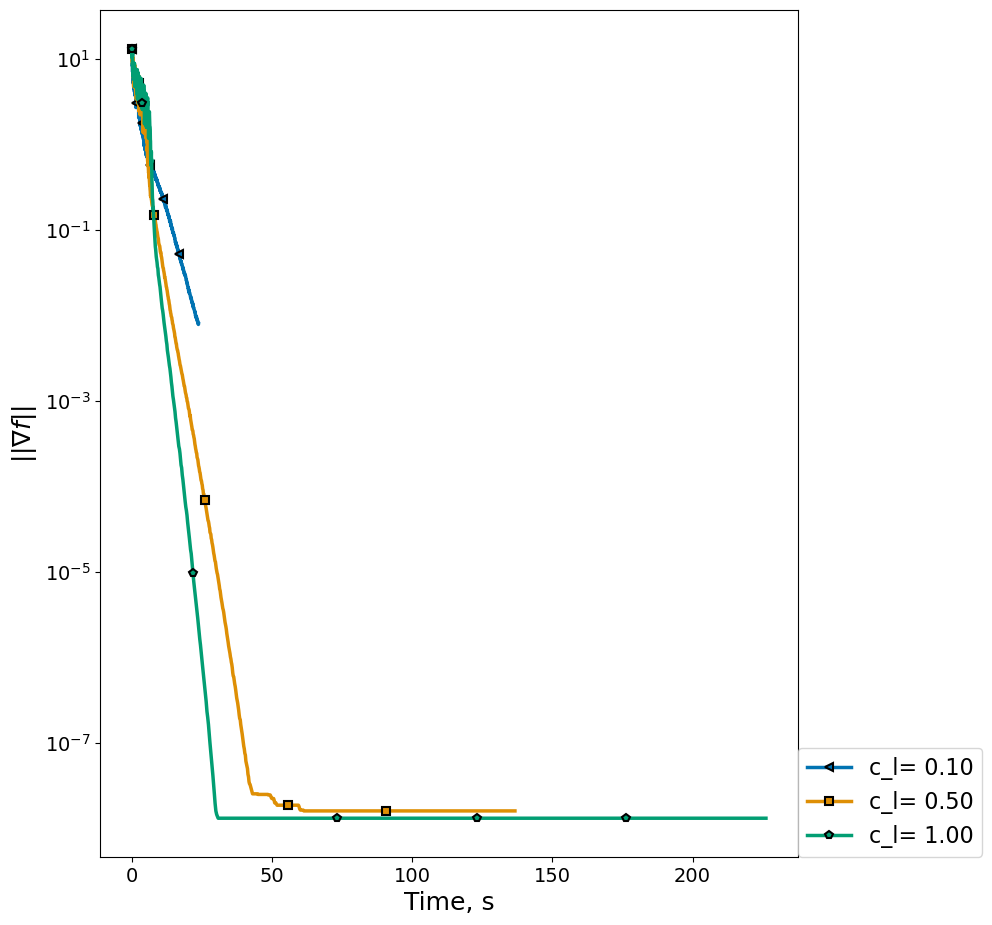

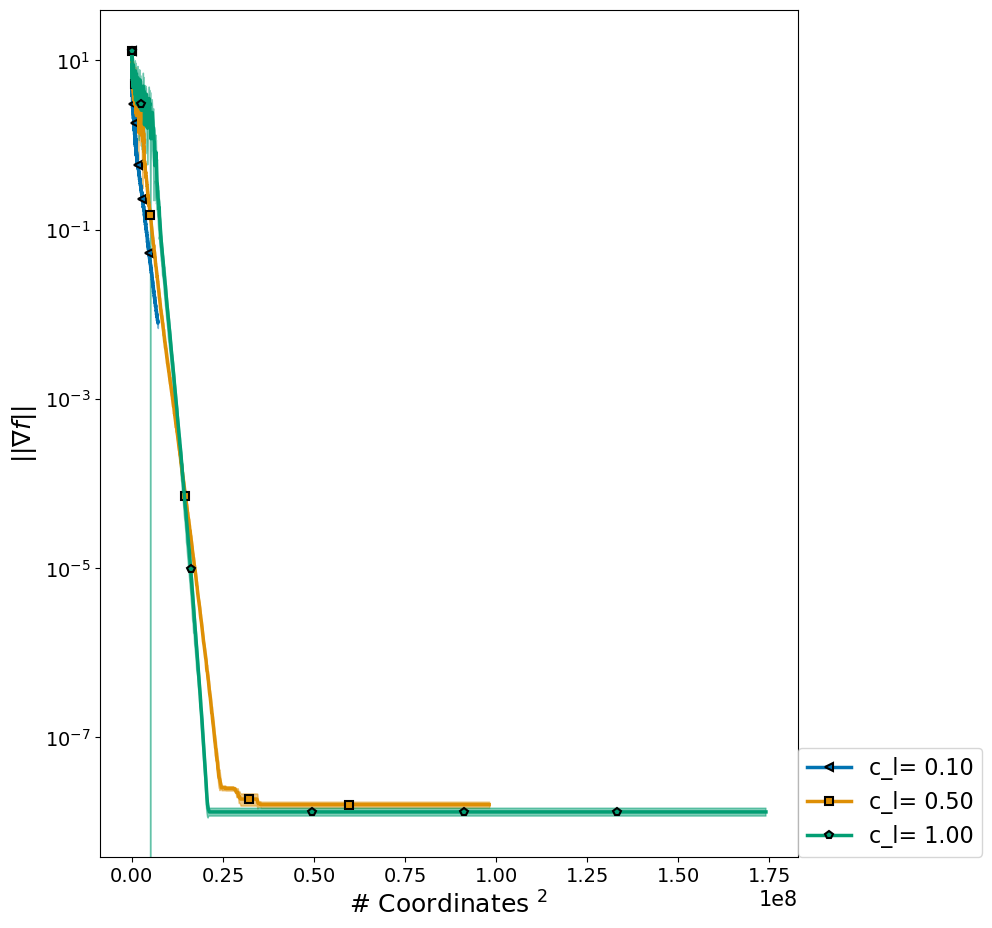

In [401]:
# logsumexp Experiment: n=500, Plotting results, linear schedule

scales_lin=[0.1,0.5,1.0]

plot_results(SSCN_logsumexp_n500_lin, None, [(r'c_l= %.2f' % (scale)) 
                                                     for scale in scales_lin 
                                                     ],
                 '', 'Iterations $k$', figurename ='logsumexp_n=%d_lam=%.3f_linear' % (n,lams[0]))

plot_results(SSCN_logsumexp_n500_lin, 'time', [(r'c_l= %.2f' % (scale)) 
                                                     for scale in scales_lin 
                                                     ],
                 '' , 'Time, s', figurename ='logsumexp_n=%d_lam=%.3f_linear' % (n,lams[0]))

plot_results(SSCN_logsumexp_n500_lin, 'num_coord_squared', 
             [(r'c_l= %.2f' % (scale)) for scale in scales_lin],
             '', r'# Coordinates $^2$', figurename ='logsumexp_n=%d_lam=%.3f_linear' % (n,lams[0]))

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.0010 	 tau 30 	 status                                    iterations_exceeded 	 time 21.9087 	 c 0.5000 	 d 0.0050
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.0010 	 tau 30 	 status                                    iterations_exceeded 	 time 78.3421 	 c 0.5000 	 d 0.0070
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.0010 	 tau 30 	 status                                    iterations_exceeded 	 time 210.1742 	 c 0.5000 	 d 0.0100
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.0010 	 tau 30 	 status                                    iterations_exceeded 	 time 14.2591 	 c 0.5000 	 d 0.0050
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.0010 	 tau 30 	 status                                    iterations_exceeded 	 time 69.5231 	 c 0.5000 	 d 0.0070
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.0010 	 tau 30 	 status              

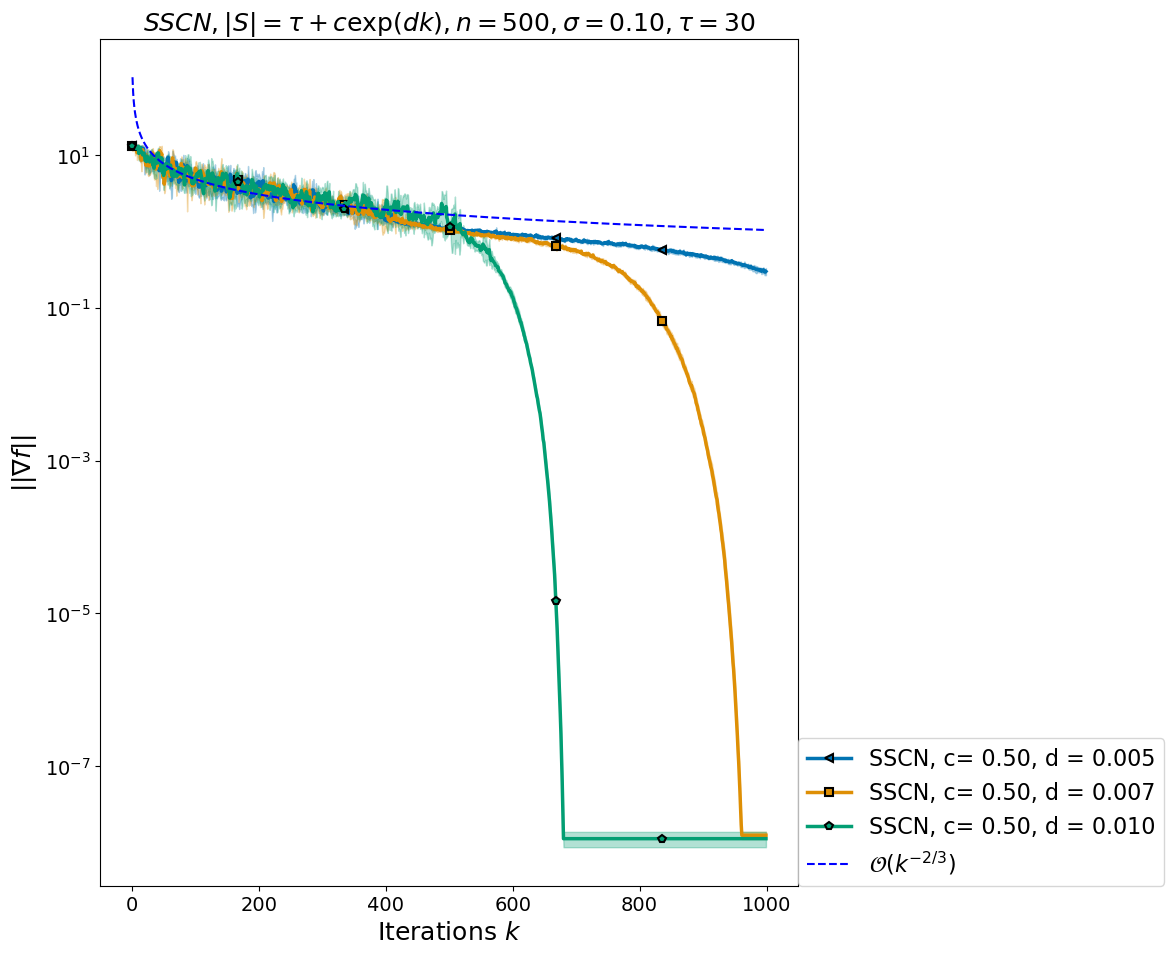

In [338]:
# Creating dataset
n = 500
mu = 0.1
(A, b, mu, x_star, f_star) = generate_logsumexp(n=n, mu=mu)
x_0 = np.ones(n)

rep = 5
seed = 31415

np.random.seed(seed)

tolerance = 1e-15
max_newton_iter = 1000
solver = 'exact'

lams = [1e-3]
taus = [30]

# exponential coordinate schedule
_, SSCN_logsumexp_n500_exp = do_experiment_logsumexp(loss, grad_x, hess_vec, hessian, solver,
                  rep, n, mu, lams, taus, schedule='exponential', cs=[0.5], exps=[0.005, 0.007, 0.01],
                                                               figurename='logsumexp_n=%d_lam=%.3f_exp' % (n,lams[0]))

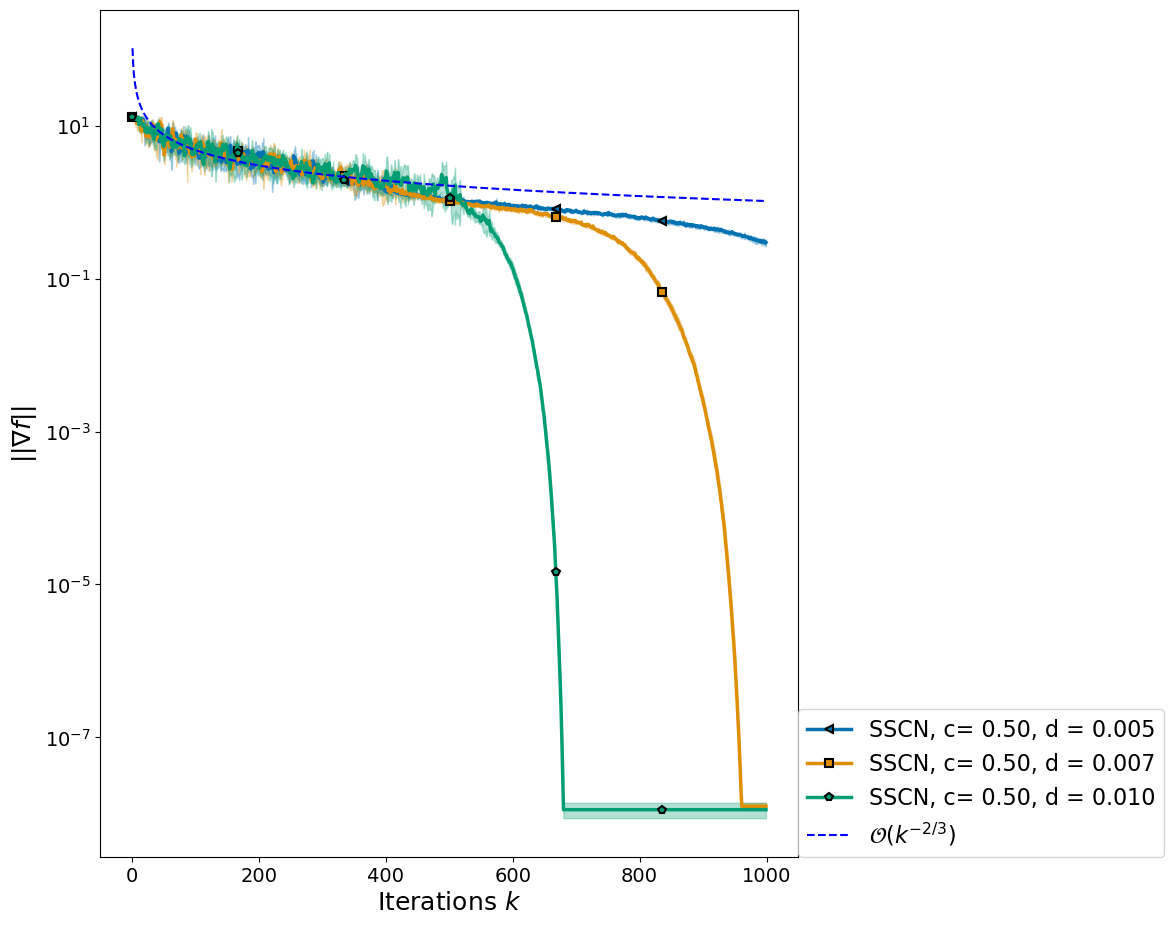

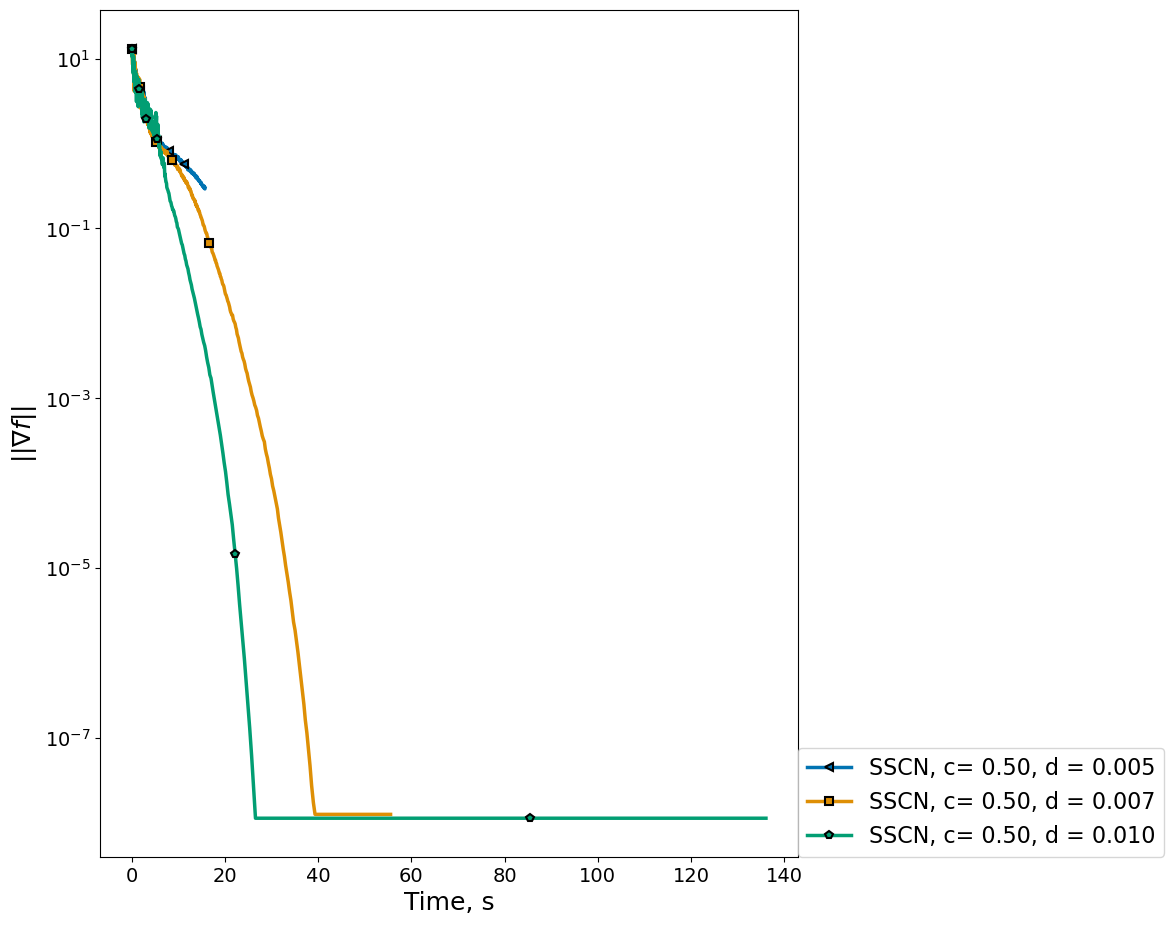

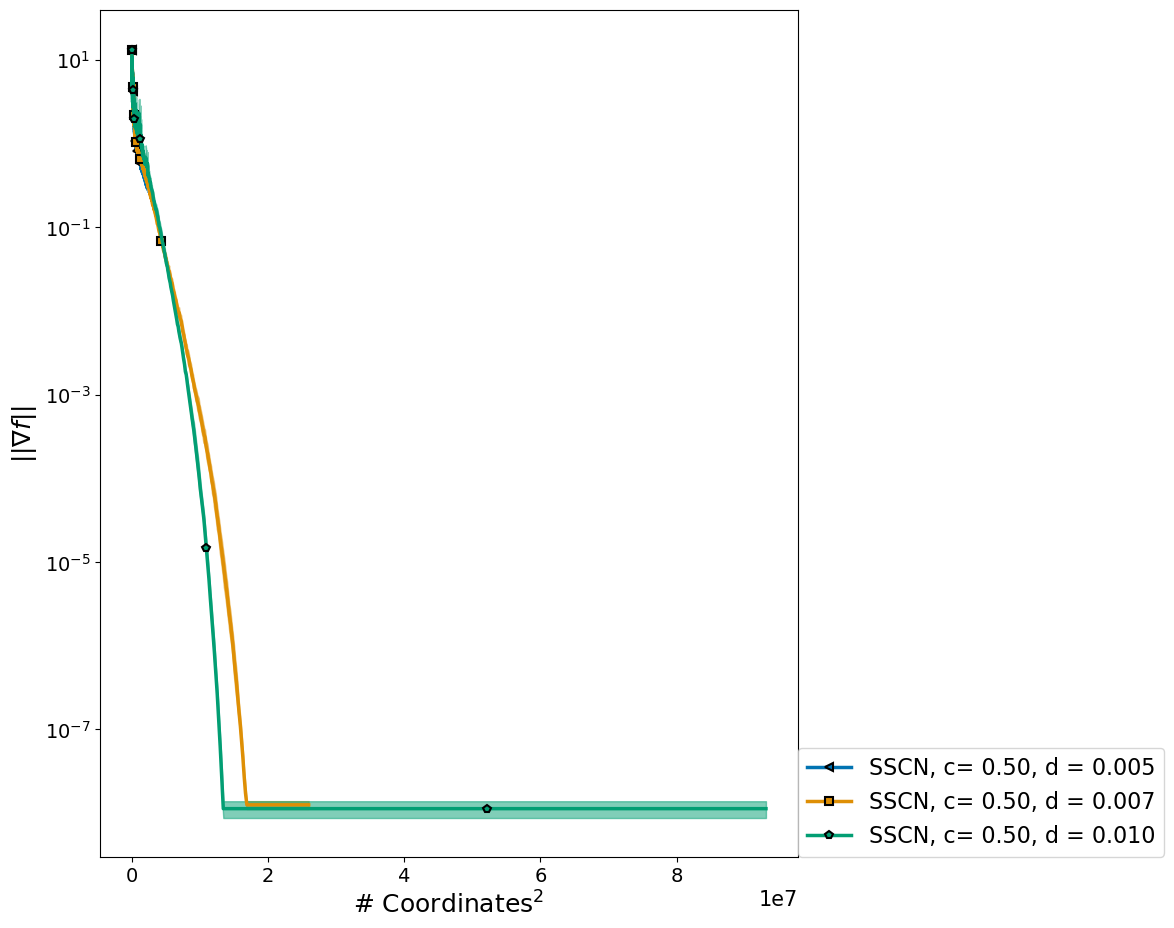

In [402]:
# logsumexp Experiment: n=500, Plotting results

cs=[0.5]
exps=[0.005, 0.007, 0.01]

plot_results(SSCN_logsumexp_n500_exp, None, [(r'SSCN, c= %.2f, d = %.3f' % (c, exp)) 
                                                     for c in cs 
                                                     for exp in exps 
                                                     ],
                 '', 'Iterations $k$', figurename ='logsumexp_n=%d_lam=%.3f_exp' % (n,lams[0]))

plot_results(SSCN_logsumexp_n500_exp, 'time', [(r'SSCN, c= %.2f, d = %.3f' % (c, exp)) 
                                                     for c in cs 
                                                     for exp in exps 
                                                     ],
                 '' , 'Time, s', figurename ='logsumexp_n=%d_lam=%.3f_exp' % (n,lams[0]))

plot_results(SSCN_logsumexp_n500_exp, 'num_coord_squared', [(r'SSCN, c= %.2f, d = %.3f' % (c, exp))
                                                     for c in cs 
                                                     for exp in exps 
                                                     ],
             '', r'# Coordinates$^2$', figurename ='logsumexp_n=%d_lam=%.3f_exp' % (n,lams[0]))

In [232]:
SSCN_logsumexp_const_schedule_n500_exp[0][-1]['grad'][680]

9.270370210512867e-09

Text(0.5, 1.0, 'Full gradient norm and rescaled gradient norm on coordinate subset')

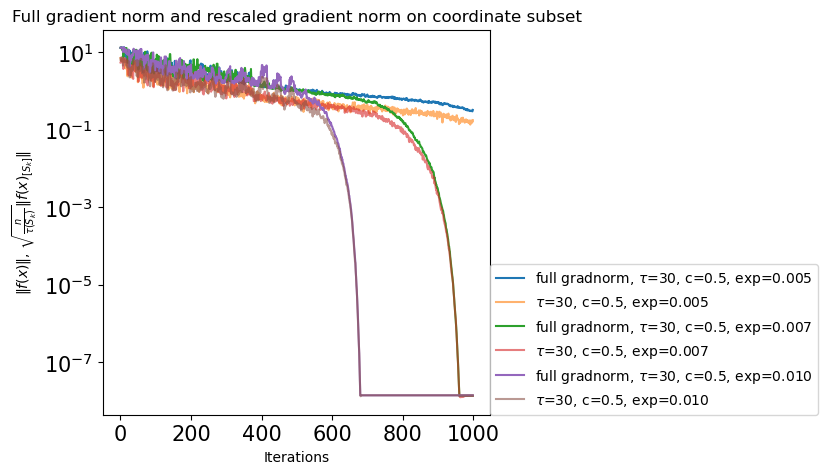

In [180]:
tau = 30
cs=[0.5]
exps=[0.005, 0.007, 0.01]
iterations = 1000


exp_results = SSCN_logsumexp_n500_exp

# for j in range(len(exp_results)):
plt.figure(figsize=(5,5))
for i in range(len(exp_results[0])):
    tau_schedule = np.minimum(np.int64(np.floor(tau+cs[0]*np.exp(exps[i]*np.arange(0,iterations)))),len(w_0))
    
    grad = exp_results[j][i]['grad']
    grad_S = exp_results[j][i]['grad_S']

    plt.semilogy(grad, label=r'full gradnorm, $\tau$=%d, c=%.1f, exp=%.3f' %(tau, cs[0], exps[i]), alpha=1)
    plt.semilogy((len(w_0)/tau_schedule)**0.5*np.array(grad_S), label=r'$\tau$=%d, c=%.1f, exp=%.3f' %(tau, cs[0], exps[i]), alpha=0.6)


plt.legend(loc=(1,0))
plt.xlabel('Iterations')
plt.ylabel(r'$\|f(x)\|$, $\sqrt{\frac{n}{\tau(S_k)}} \|f(x)_{[S_k]}\|$')
plt.title('Full gradient norm and rescaled gradient norm on coordinate subset')

Experiment: 	 n = 500, 	 mu = 0.050000.
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 30 	 status                            iterations_exceeded 	 time 10.0351
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 100 	 status                            success 	 time 27.2409
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 200 	 status                            success 	 time 17.8619
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 500 	 status                            success 	 time 18.9193



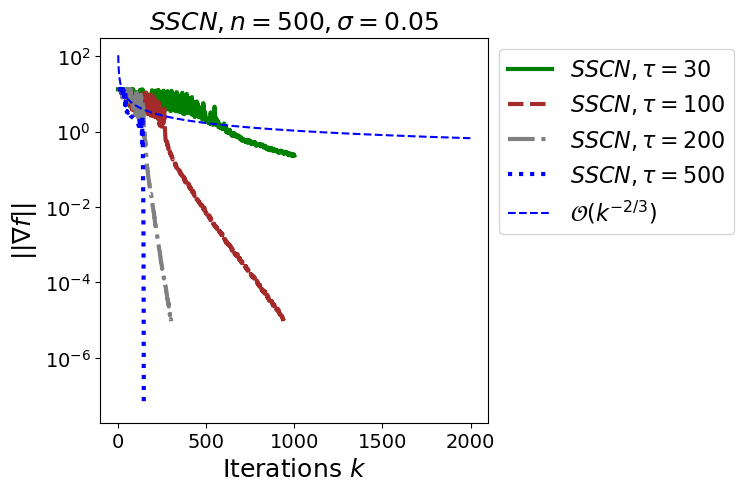

In [15]:
# n=500, Experiment for constant schedules
rep = 1
seed = 31415

np.random.seed(seed)

SSCN_results_const_new = do_experiment(n=500, mu=0.05, lams=[0.1], taus=[30], 
                                   schedule='constant')

Experiment: 	 n = 500, 	 mu = 0.010000.
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 50 	 status                            iterations_exceeded 	 time 12.3178
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 100 	 status                            iterations_exceeded 	 time 21.2970
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 200 	 status                            iterations_exceeded 	 time 42.9868
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 500 	 status                            success 	 time 117.9712



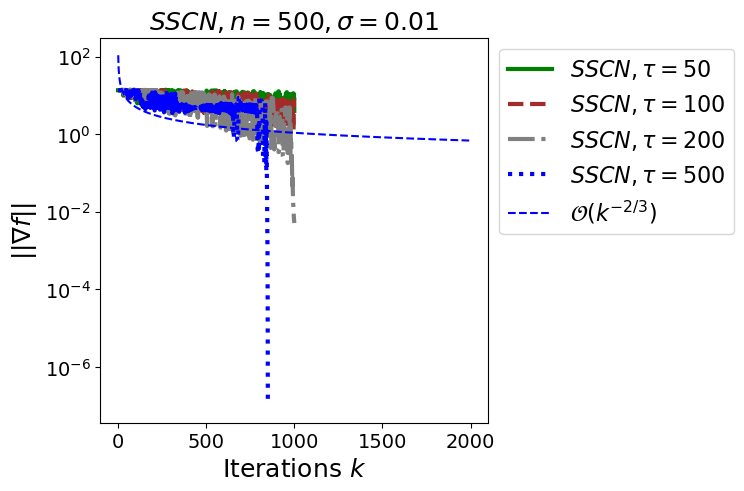

In [16]:
# n=500, Experiment for constant schedules
rep = 1
seed = 31415

np.random.seed(seed)

for it in range(rep):
    SSCN_results_const_new = do_experiment(n=500, mu=0.01, lams=[0.1], taus=[50,100,200,500], 
                                       schedule='constant')

In [ ]:
# # n=500, Experiment for constant schedules
# rep = 1
# seed = 31415

# np.random.seed(seed)

# for it in range(rep):
#     SSCN_results_const_new = do_experiment(n=500, mu=0.1, lams=[0.3], taus=[30,100,200,500], 
#                                        schedule='constant')

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with linear schedule tau+s*k 	 : lambda 0.1000 	 tau 30 	 status                                iterations_exceeded 	 time 16.6506 	 c 0.0500



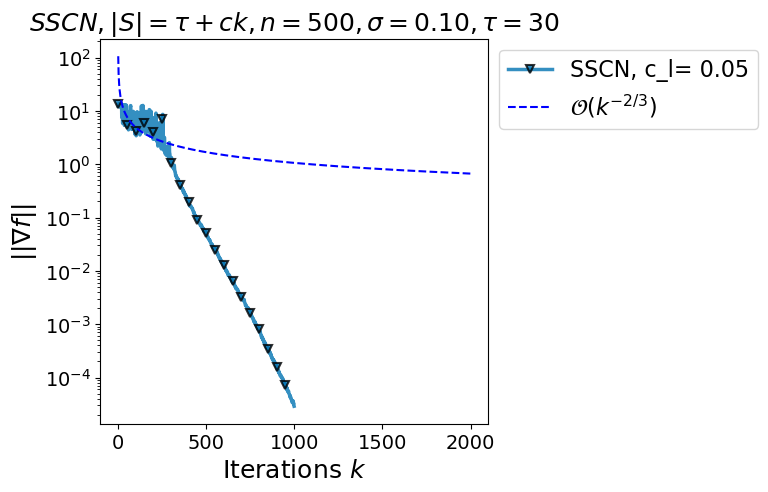

In [101]:
# n=200, Experiment for linear schedules

rep = 1
seed = 31415

np.random.seed(seed)

SSCN_results_lin_new = do_experiment(loss, grad_x, hess_vec, hessian, 
                                   rep=rep, n=500, mu=0.1, lams=[0.1], taus=[30], 
                                   schedule='linear', scales_lin=[0.05])

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with quadratic schedule tau+s*k^2 	 : lambda 0.1000 	 tau 30 	 status                                iterations_exceeded 	 time 14.3711 	 c 0.0001
SSCN with quadratic schedule tau+s*k^2 	 : lambda 0.1000 	 tau 30 	 status                                success 	 time 32.1958 	 c 0.0001
SSCN with quadratic schedule tau+s*k^2 	 : lambda 0.1000 	 tau 30 	 status                                success 	 time 48.8598 	 c 0.0002
SSCN with quadratic schedule tau+s*k^2 	 : lambda 0.1000 	 tau 30 	 status                                success 	 time 63.6014 	 c 0.0005



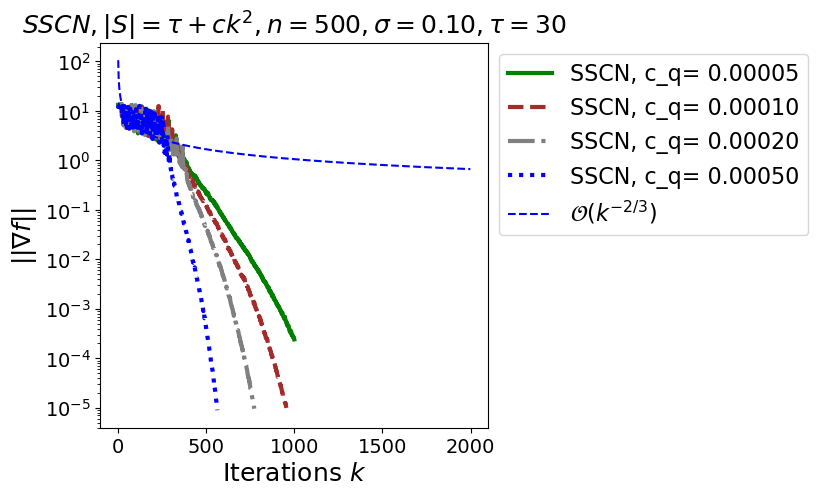

In [24]:
# n=200, Experiment for quadratic schedules

rep = 1
seed = 31415

np.random.seed(seed)

SSCN_results_quad_new = do_experiment(n=500, mu=0.1, lams=[0.1], taus=[30], 
                                   schedule='quadratic', scales_quad = [0.00005, 0.0001, 0.0002, 0.0005])

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    iterations_exceeded 	 time 11.0423 	 c 0.1000 	 d 0.0050
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    iterations_exceeded 	 time 22.7669 	 c 0.2000 	 d 0.0050
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    success 	 time 38.8715 	 c 0.1000 	 d 0.0100
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    success 	 time 54.4888 	 c 0.2000 	 d 0.0100
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    success 	 time 65.3109 	 c 0.1000 	 d 0.0200
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    success 	 time 

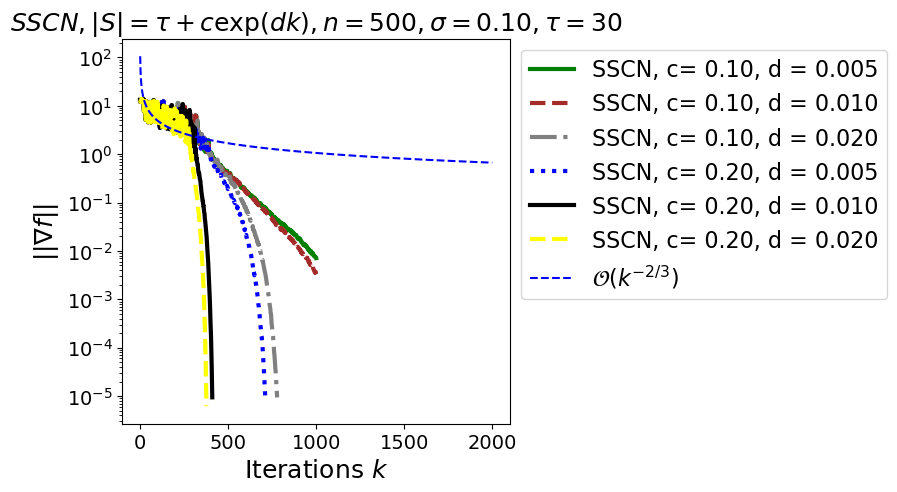

In [27]:
rep = 1
seed = 31415

np.random.seed(seed)

SSCN_results_exp_new = do_experiment(n=500, mu=0.1, lams=[0.1], taus=[30], 
                                    schedule='exponential', cs=[0.1, 0.2], exps=[0.005, 0.01, 0.02])

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    iterations_exceeded 	 time 11.7237 	 c 0.2000 	 d 0.0050

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    iterations_exceeded 	 time 11.7948 	 c 0.2000 	 d 0.0050

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    iterations_exceeded 	 time 11.6854 	 c 0.2000 	 d 0.0050

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    iterations_exceeded 	 time 11.6424 	 c 0.2000 	 d 0.0050

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                        

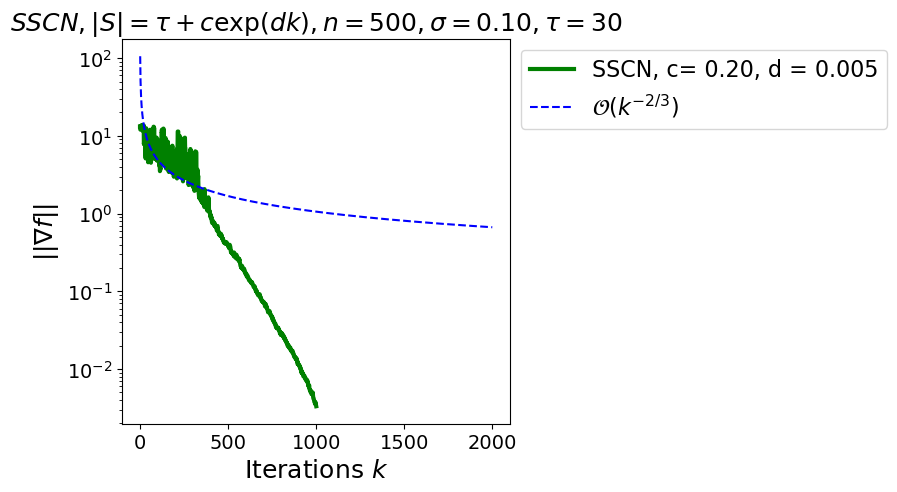

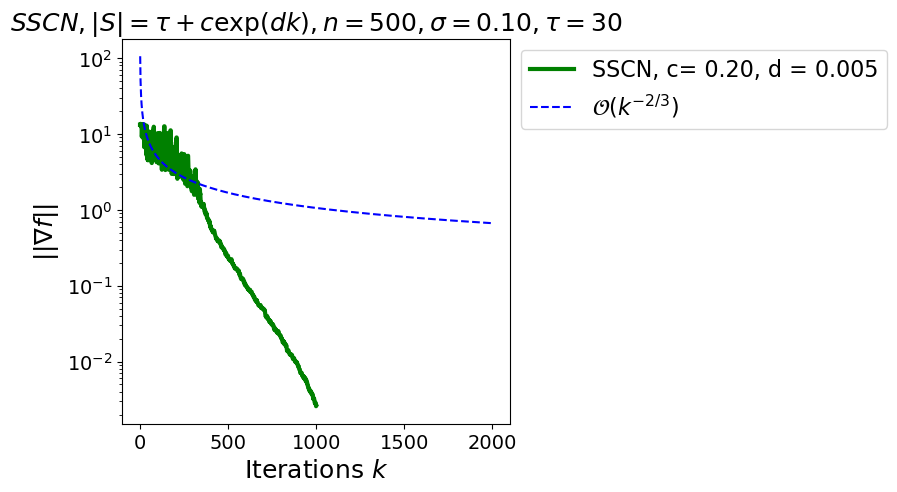

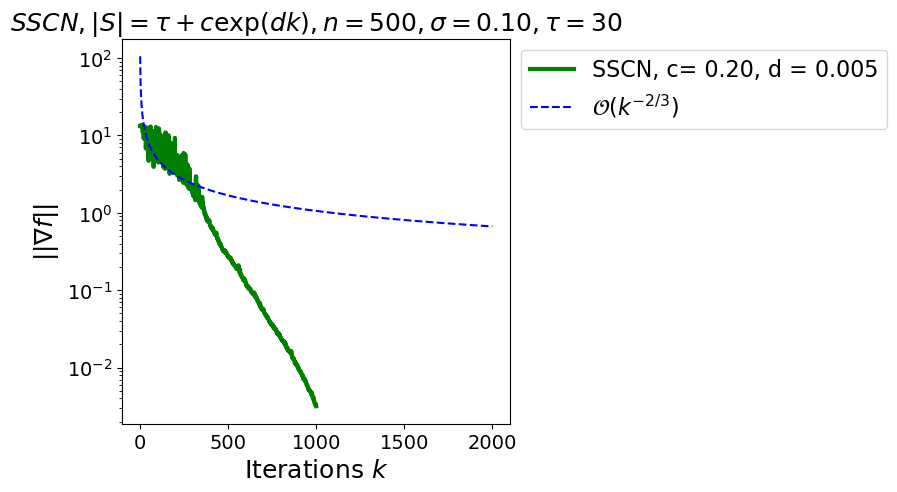

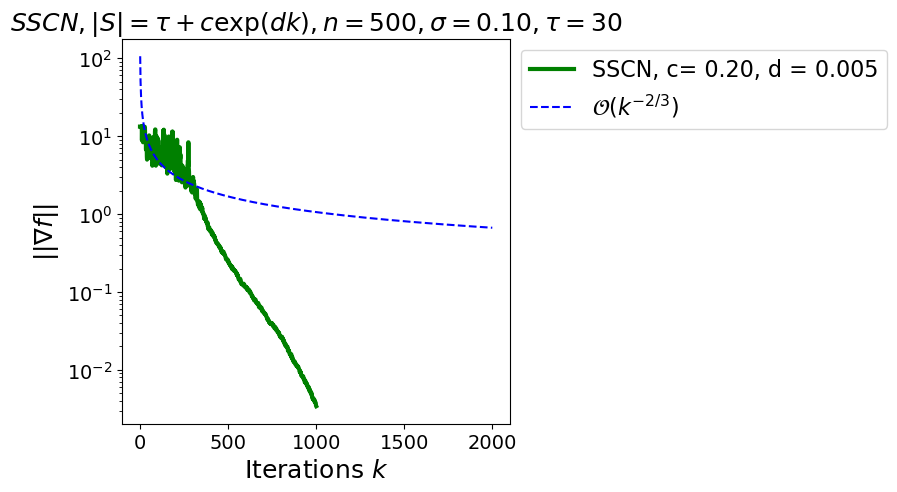

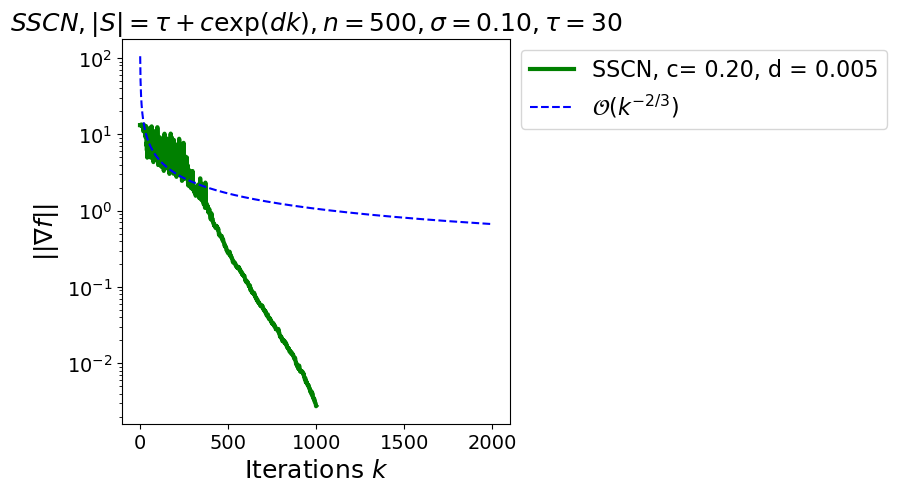

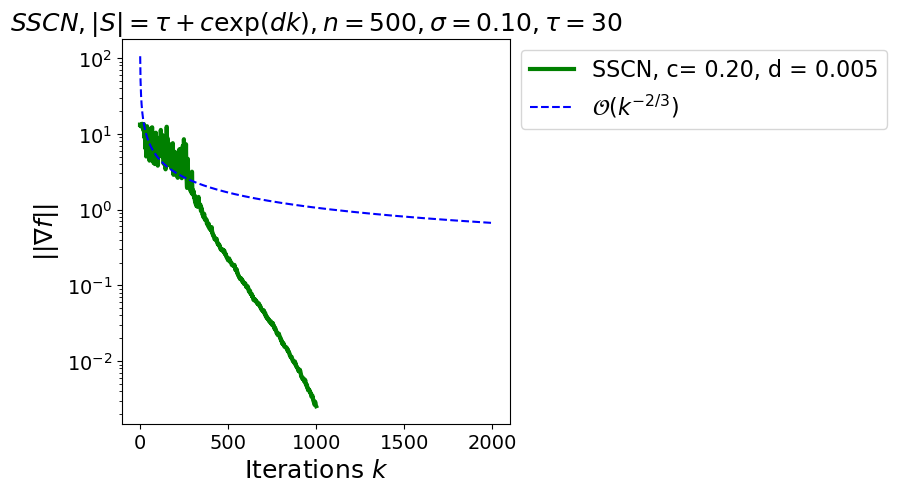

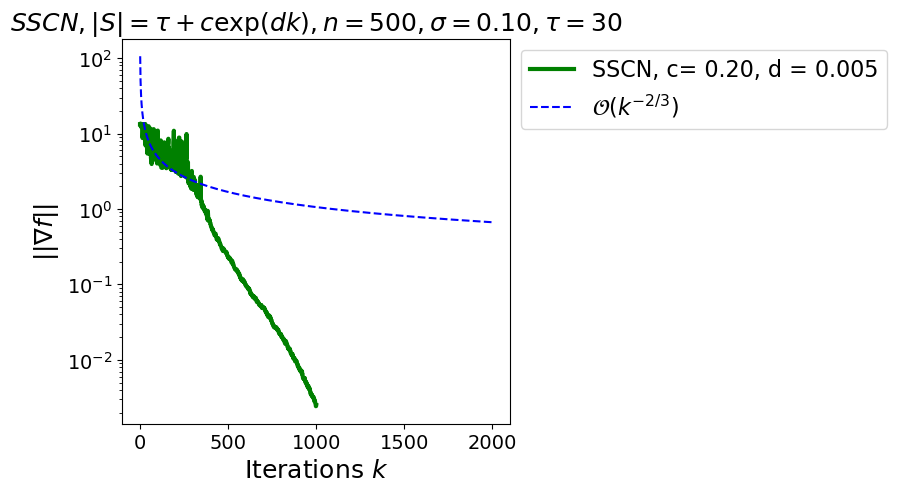

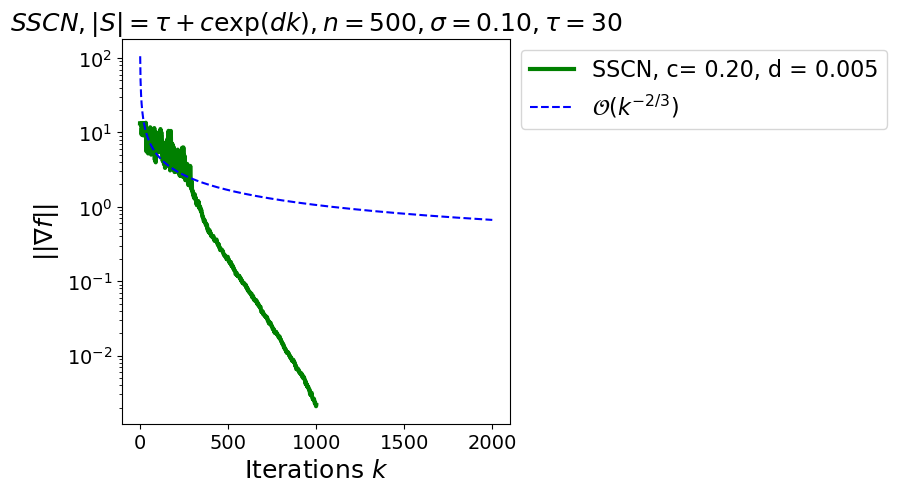

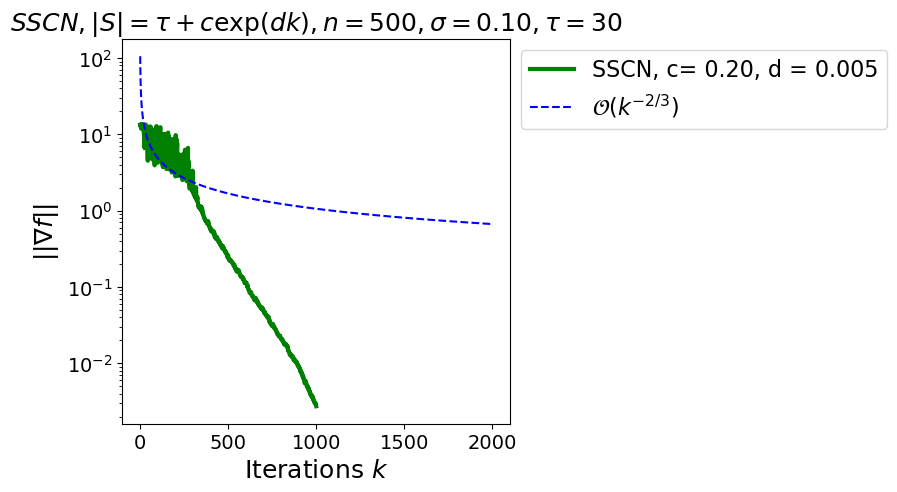

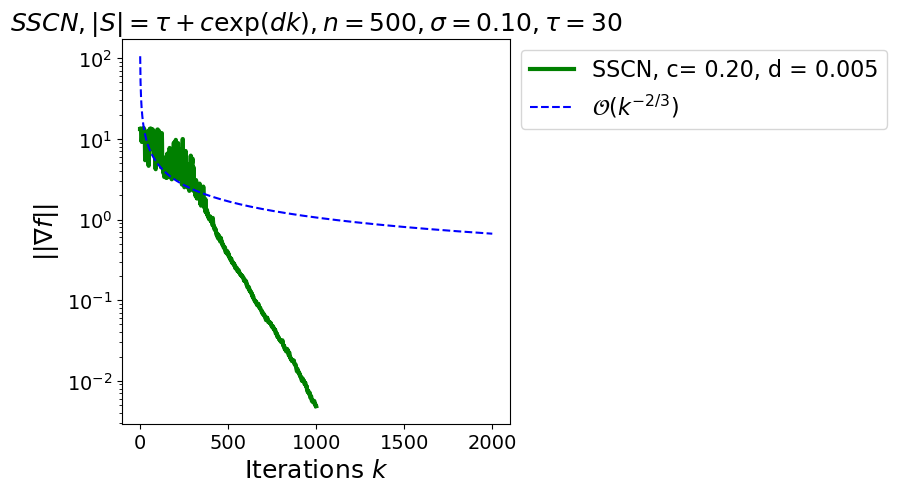

In [53]:
rep = 10

n=500
mu=0.1
(A, b, mu, x_star, f_star) = generate_logsumexp(n=n, mu=mu)
x_0 = np.ones(n)
#     x_0 = 10*np.random.randn(n)
tolerance = 1e-5
max_newton_iter = 1000

seed = 31415

np.random.seed(seed)

SSCN_results_exp_news = []

for i in range(rep):
    SSCN_results_exp_new = do_experiment(n=500, mu=0.1, lams=[0.1], taus=[30], 
                                        schedule='exponential', cs=[0.2], exps=[0.005])
    SSCN_results_exp_news.append(SSCN_results_exp_new)

Text(0.5, 1.0, 'Learning curve for different intializations')

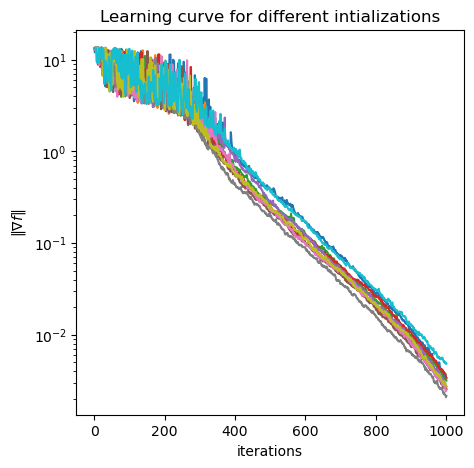

In [56]:
for i in range(rep):
    plt.semilogy(SSCN_results_exp_news[i][0]['grad'])
    
plt.ylabel(r'$ \|\nabla f \| $')
plt.xlabel('iterations')
plt.title('Learning curve for different intializations')

Text(0.5, 1.0, 'Exponential coordinate schedule')

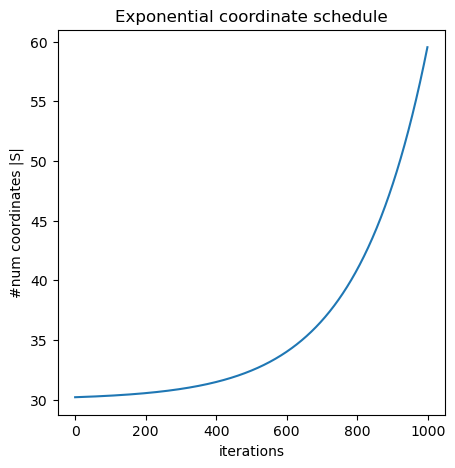

In [59]:
tau = 30
c = 0.2
d = 0.005
k = 1000
plt.plot(np.arange(0,k),tau+c*np.exp(d*np.arange(0,k)))
plt.xlabel('iterations')
plt.ylabel('#num coordinates |S|')
plt.title('Exponential coordinate schedule')

Experiment: 	 n = 500, 	 mu = 0.100000.
W: line_search_max_iters reached.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    success 	 time 9.4529 	 c 0.1000 	 d 0.0050
W: line_search_max_iters reached.
W: line_search_max_iters reached.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    success 	 time 18.4147 	 c 1.0000 	 d 0.0050
W: line_search_max_iters reached.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    success 	 time 26.5318 	 c 0.1000 	 d 0.0100
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    success 	 time 34.4412 	 c 1.0000 	 d 0.0100
W: line_search_max_iters reached.
SSCN with exponential schedule tau+c*e^(d*k) 	 : lambda 0.1000 	 tau 30 	 status                                    success 	 time 43.6797 	 c 0.10

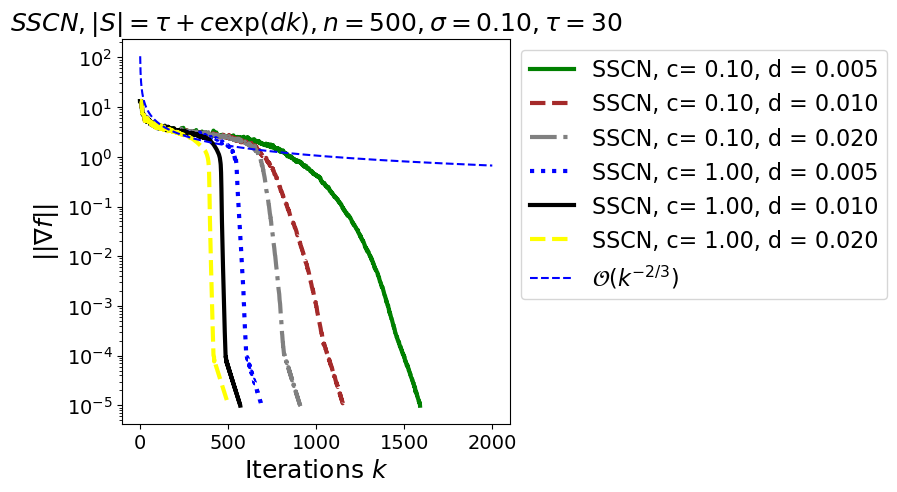

In [25]:
# n=500, Experiment for exponential schedules

rep = 1
seed = 31415

np.random.seed(seed)

SSCN_results_exp = do_experiment_old(n=500, mu=0.1, lams=[0.1], taus=[30], 
                                    schedule='exponential', cs=[0.1, 1], exps=[0.005, 0.01, 0.02])

In [19]:
def do_experiment_old(n, mu, lams, taus, schedule='constant', scales_lin=[1.0], scales_quad=[1.0], cs=[1.0], exps=[1.0]):
    print('Experiment: \t n = %d, \t mu = %f.' % (n, mu))

    (A, b, mu, x_star, f_star) = generate_logsumexp(n=n, mu=mu)
    x_0 = np.ones(n)
    tolerance = 1e-5
    max_iter= 10000
    max_newton_iter = 10000

#     CD_results = []
#     for lam in lams:
#         for tau in taus:
#             start_timestamp = datetime.now()
#             _, status, history = \
#                 coordinate_gradient_method(A, b, mu, lam, x_0, tolerance=tolerance, 
#                                            f_star=f_star, tau=tau,
#                                            max_iter=max_iter,
#                                            L_0 = 1.0, line_search=True)
#             t_secs = (datetime.now() - start_timestamp).total_seconds()
#             print(('CD \t : lambda %.4f \t tau %d \t status %s \t time: %.4f' % 
#                   (lam, tau, status, t_secs)), flush=True)

#             CD_results.append(history)
    
    SSCN_results = []
    for lam in lams:
            for tau in taus:
                start_timestamp = datetime.now()
                
                if schedule == 'exponential':
                    for exp in exps:
                        for c in cs:
                        
                            _, status, history = \
                                coordinate_cubic_newton(A, b, mu, lam, x_0, tolerance=tolerance, 
                                                        f_star=f_star, tau=tau,
                                                        max_iter=max_newton_iter,
                                                        H_0 = 1.0, line_search=True, schedule=schedule, 
                                                        c=c, exp=exp)
                            t_secs = (datetime.now() - start_timestamp).total_seconds()
                            print(('SSCN with exponential schedule tau+c*e^(d*k) \t : lambda %.4f \t tau %d \t status \
                                   %s \t time %.4f \t c %.4f \t d %.4f'  % 
                                  (lam, tau, status, t_secs, c, exp)), flush=True)
                            SSCN_results.append(history)
                elif schedule == 'linear':
                    for scale in scales_lin:
                        _, status, history = \
                            coordinate_cubic_newton(A, b, mu, lam, x_0, tolerance=tolerance, 
                                                    f_star=f_star, tau=tau,
                                                    max_iter=max_newton_iter,
                                                    H_0 = 1.0, line_search=True, schedule=schedule, 
                                                    scale_lin=scale)
                        t_secs = (datetime.now() - start_timestamp).total_seconds()
                        print(('SSCN with linear schedule tau+s*k \t : lambda %.4f \t tau %d \t status \
                               %s \t time %.4f \t c %.4f'  % 
                              (lam, tau, status, t_secs, scale)), flush=True)
                        SSCN_results.append(history)
                elif schedule == 'quadratic':
                    for scale in scales_quad:
                        _, status, history = \
                            coordinate_cubic_newton(A, b, mu, lam, x_0, tolerance=tolerance, 
                                                    f_star=f_star, tau=tau,
                                                    max_iter=max_newton_iter,
                                                    H_0 = 1.0, line_search=True, schedule=schedule, 
                                                    scale_quad=scale)
                        t_secs = (datetime.now() - start_timestamp).total_seconds()
                        print(('SSCN with quadratic schedule tau+s*k^2 \t : lambda %.4f \t tau %d \t status \
                               %s \t time %.4f \t c %.4f'  % 
                              (lam, tau, status, t_secs, scale)), flush=True)
                        SSCN_results.append(history)
                else:
                    _, status, history = \
                            coordinate_cubic_newton(A, b, mu, lam, x_0, tolerance=tolerance, 
                                                    f_star=f_star, tau=tau,
                                                    max_iter=max_newton_iter,
                                                    H_0 = 1.0, line_search=True, schedule=schedule)
                    t_secs = (datetime.now() - start_timestamp).total_seconds()
                    print(('SSCN with const schedule tau \t : lambda %.4f \t tau %d \t status \
                           %s \t time %.4f'  % 
                          (lam, tau, status, t_secs)), flush=True)
                    SSCN_results.append(history)
                        

    print('')
    colors = ['green','brown','gray','blue','black','yellow', 'orange', 'red','pink','purple','magenta']
    linestyles = ['-', '--', '-.', ':'] * (int(len(taus) * len(lams) * len(scales_lin) * len(scales_quad) * len(exps) * len(cs)/4) + 1)
    
    linewidths = [3] * len(taus) * len(lams) * len(scales_lin) * len(scales_quad) * len(exps) * len(cs)
    alphas = [1] * len(taus) * len(lams) * len(scales_lin) * len(scales_quad) *len(exps) * len(cs)

    folder = os.getcwd()+'/plots'
    mu_str = ('%.2f' % mu)[2:]

    
#     plot_results([SSCN_results], 'time', f_star, [[('SSCN %d' % tau) for tau in taus]],
#                  colors, linestyles, linewidths, alphas,
#                  (r'$SSCN, n = %d, \sigma = %.2f$' % (n, mu)), 'Time, s')
    
    if schedule == 'constant':
        plot_results([SSCN_results], None, f_star, [[(r'$SSCN, \tau = %d$' % (tau)) 
                                                     for tau in taus 
                                                     ]],
                 colors, linestyles, linewidths, alphas,
                 (r'$SSCN, n = %d, \sigma = %.2f$' % (n, mu)), 'Iterations $k$')
    elif schedule == 'linear':
        plot_results([SSCN_results], None, f_star, [[(r'SSCN, c_l= %.2f' % (scale)) 
                                                     for scale in scales_lin 
                                                     ]],
                 colors, linestyles, linewidths, alphas,
                 (r'$SSCN, |S|=\tau + c k, n = %d, \sigma = %.2f, \tau = %d$' % (n, mu, tau)), 'Iterations $k$')
    elif schedule == 'exponential':
        plot_results([SSCN_results], None, f_star, [[(r'SSCN, c= %.2f, d = %.3f' % (c, exp)) 
                                                     for c in cs 
                                                     for exp in exps 
                                                     ]],
                 colors, linestyles, linewidths, alphas,
                 (r'$SSCN, |S|=\tau + c \exp(d k), n = %d, \sigma = %.2f, \tau = %d$' % (n, mu, tau)), 'Iterations $k$')
    elif schedule == 'quadratic':
        plot_results([SSCN_results], None, f_star, [[(r'SSCN, c_q= %.5f' % (scale)) 
                                                     for scale in scales_quad 
                                                     ]],
                 colors, linestyles, linewidths, alphas,
                 (r'$SSCN, |S|=\tau + c k^2, n = %d, \sigma = %.2f, \tau = %d$' % (n, mu, tau)), 'Iterations $k$')

    return SSCN_results
        
#     plot_results([CD_results], 'time', f_star, [[('CD %d' % tau) for tau in taus]],
#              colors, linestyles, linewidths, alphas,
#              (r'$CD , n = %d, \sigma = %.2f$' % (n, mu)), 'Time, s')
    
#     plot_results([CD_results], None, f_star, [[('CD %d' % tau) for tau in taus]],
#              colors, linestyles, linewidths, alphas,
#              (r'$CD , n = %d, \sigma = %.2f$' % (n, mu)), 'Iterations')
    
    
    
    # Plot CD results vs. SSCN results in the same plot
    
#     plot_results([CD_results,SSCN_results], 'time', f_star, [[('CD %d' % tau) for tau in taus],[('SSCN %d' % tau) for tau in taus]],
#                  colors, linestyles, linewidths, alphas,
#                  (r'$CD & SSCN, n = %d, \sigma = %.2f$' % (n, mu)), 'Time, s')
    
#     plot_results([CD_results,SSCN_results], None, f_star, [[('CD %d' % tau) for tau in taus],[('SSCN %d' % tau) for tau in taus]],
#              colors, linestyles, linewidths, alphas,
#              (r'$CD & SSCN, n = %d, \sigma = %.2f$' % (n, mu)), 'Iterations')


# #     plt.savefig('%s/logsumexp_CD_%d_%s_time.pdf' % (folder, n, mu_str))

Experiment: 	 n = 500, 	 mu = 0.100000.
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 50 	 status                            success 	 time 10.2763
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 100 	 status                            success 	 time 11.7220


/users/staff/dmi-dmi/zhao0005/Subspace Cubic Newton/logsumexp_coordinate_methods.py:176: RuntimeWarning: overflow encountered in scalar power
  + H / r * (h * pk_pk - xk_pk) ** 2
/users/staff/dmi-dmi/zhao0005/Subspace Cubic Newton/logsumexp_coordinate_methods.py:176: RuntimeWarning: invalid value encountered in scalar multiply
  + H / r * (h * pk_pk - xk_pk) ** 2


W: cubic newton step status: iterations_exceeded 


/users/staff/dmi-dmi/zhao0005/Subspace Cubic Newton/logsumexp_coordinate_methods.py:170: RuntimeWarning: overflow encountered in scalar multiply
  + h * (A_pk_pk + H * r * pk_pk) \
/users/staff/dmi-dmi/zhao0005/Subspace Cubic Newton/logsumexp_coordinate_methods.py:175: RuntimeWarning: overflow encountered in scalar multiply
  g_H = A_pk_pk + H * r * pk_pk \
/users/staff/dmi-dmi/zhao0005/Subspace Cubic Newton/logsumexp_coordinate_methods.py:177: RuntimeWarning: invalid value encountered in scalar divide
  h = h - g_G / g_H


W: cubic newton step status: iterations_exceeded 


/users/staff/dmi-dmi/zhao0005/Subspace Cubic Newton/logsumexp_coordinate_methods.py:171: RuntimeWarning: overflow encountered in scalar multiply
  - H * r * xk_pk
/users/staff/dmi-dmi/zhao0005/Subspace Cubic Newton/logsumexp_coordinate_methods.py:169: RuntimeWarning: invalid value encountered in scalar subtract
  g_G =  - g_p_k - A_pk_xk \


W: cubic newton step status: iterations_exceeded 
W: line_search_max_iters reached.
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 200 	 status                            success 	 time 27.9455
W: cubic newton step status: iterations_exceeded 


/users/staff/dmi-dmi/zhao0005/Subspace Cubic Newton/logsumexp_coordinate_methods.py:207: RuntimeWarning: invalid value encountered in multiply
  p_k = g_T - beta_k * p_k


W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: line_search_max_iters reached.
SSCN with const schedule tau 	 : lambda 0.1000 	 tau 500 	 status                            success 	 time 86.0076



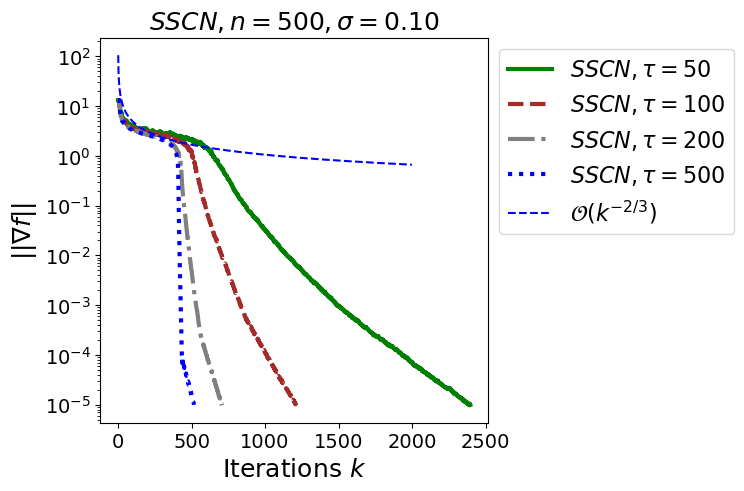

In [21]:
# n=500, Experiment for constant schedules
rep = 1
seed = 31415

np.random.seed(seed)

for it in range(rep):
    SSCN_results_const = do_experiment_old(n=500, mu=0.1, lams=[0.1], taus=[30, 100, 200, 500], 
                                       schedule='constant')

In [22]:
# n=500, Experiment for constant schedules
rep = 1
seed = 31415

np.random.seed(seed)

for it in range(rep):
    SSCN_results_const = do_experiment_old(n=500, mu=0.1, lams=[0.3], taus=[30, 100, 200, 500], 
                                       schedule='constant')

Experiment: 	 n = 500, 	 mu = 0.100000.


/users/staff/dmi-dmi/zhao0005/Subspace Cubic Newton/logsumexp_coordinate_methods.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  beta_k = g_T.dot(g_T) / (g_T - g_k).dot(p_k)


W: cubic newton step status: iterations_exceeded 
W: line_search_max_iters reached.
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton 

W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 
W: line_search_max_iters reached.
W: cubic newton step status: iterations_exceeded 
W: cubic newton step status: iterations_exceeded 


KeyboardInterrupt: 

In [ ]:
# n=200, Experiment for linear schedules
SSCN_results_lin = do_experiment_old(n=200, mu=0.1, lams=[0.1], taus=[30], 
                                   schedule='linear', scales_lin=[0, 0.1, 0.5])

In [ ]:
# n=200, Experiment for quadratic schedules

SSCN_results_quad = do_experiment_old(n=200, mu=0.1, lams=[0.1], taus=[30], 
                                   schedule='quadratic', scales_quad = [0.00005, 0.0001, 0.0002, 0.0005])

In [ ]:
# n=200, Experiment for exponential schedules

SSCN_results_exp = do_experiment_old(n=200, mu=0.1, lams=[0.1], taus=[30], 
                                    schedule='exponential', cs=[0.1, 1], exps=[0.005, 0.01, 0.02])

In [ ]:
#n=200, Compare the schedules in the number of coordinates evaluated

taus = [30, 50, 100, 150, 200]
scales_lin = [0.1, 0.5]
scales_quad = [0.00005, 0.0001, 0.0002, 0.0005]

cs = [0.1, 1]
exps = [0.005, 0.01, 0.02]
n = 200


for ind, tau in enumerate(taus):
    plt.loglog(np.cumsum([tau]*(len(SSCN_results_const[ind]['grad']))), 
               SSCN_results_const[ind]['grad'] , ':', 
               label = r'const $\tau$=%d' % tau, linewidth = 2)
    
for ind, scale in enumerate(scales_lin):
    plt.loglog(np.cumsum(np.int64(np.minimum(np.floor(taus[0] + scale * np.arange(0,len(SSCN_results_lin[ind]['grad']))),n)
                                 )),
               SSCN_results_lin[ind]['grad'], '-.', 
               label = r'lin $\tau=%d, s=%.2f$' % (taus[0],scale), linewidth = 2)
    
for ind, scale in enumerate(scales_quad):
    plt.loglog(np.cumsum(np.int64(np.minimum(np.floor(taus[0] + 
                                                      scale * np.arange(0,len(SSCN_results_quad[ind]['grad']))**2),n)
                        )),
               SSCN_results_quad[ind]['grad'], '--', 
               label = r'quad $\tau=%d, s=%.5f$' % (taus[0],scale), linewidth = 2)

for ind_c, c in enumerate(cs):
    for ind_exp, exp in enumerate(exps):
        ind = ind_exp + ind_c*len(exps)
        plt.loglog(np.cumsum(np.int64(np.minimum(taus[0] + 
                                                 c * np.exp(exp * np.arange(0,len(SSCN_results_exp[ind]['grad']))), n ))
                            ),
                   SSCN_results_exp[ind]['grad'], '-', 
                   label = r'exp $\tau=%d, c=%.2f, d=%.3f$' % (taus[0],c,exp), linewidth = 2)

    
plt.title('Gradient norm of loss over total number of evaluated coordinates')
plt.ylabel(r'$\| \nabla f \|$')
plt.xlabel(r'$\sum$ #coordinates')
plt.legend(loc='lower left',bbox_to_anchor=(1.2,0))

In [ ]:
#n=200, Compare the schedules in the number of coordinates^2 evaluated

taus = [30, 50, 100, 150, 200]
scales_lin = [0.1, 0.5]
scales_quad = [0.00005, 0.0001, 0.0002, 0.0005]

cs = [0.1, 1]
exps = [0.005, 0.01, 0.02]
n = 200


for ind, tau in enumerate(taus):
    plt.loglog(np.cumsum([tau**2]*(len(SSCN_results_const[ind]['grad']))), 
               SSCN_results_const[ind]['grad'] , ':', 
               label = r'const $\tau$=%d' % tau, linewidth = 2)
    
for ind, scale in enumerate(scales_lin):
    plt.loglog(np.cumsum(np.int64(np.minimum(np.floor(taus[0] + scale * np.arange(0,len(SSCN_results_lin[ind]['grad']))),n)
                                 )**2),
               SSCN_results_lin[ind]['grad'], '-.', 
               label = r'lin $\tau=%d, s=%.2f$' % (taus[0],scale), linewidth = 2)
    
for ind, scale in enumerate(scales_quad):
    plt.loglog(np.cumsum(np.int64(np.minimum(np.floor(taus[0] + 
                                                      scale * np.arange(0,len(SSCN_results_quad[ind]['grad']))**2),n)
                                )**2),
               SSCN_results_quad[ind]['grad'], '--', 
               label = r'quad $\tau=%d, s=%.5f$' % (taus[0],scale), linewidth = 2)

for ind_c, c in enumerate(cs):
    for ind_exp, exp in enumerate(exps):
        ind = ind_exp + ind_c*len(exps)
        plt.loglog(np.cumsum(np.int64(np.minimum(taus[0] + 
                                                 c * np.exp(exp * np.arange(0,len(SSCN_results_exp[ind]['grad']))), n )
                                )**2),
                   SSCN_results_exp[ind]['grad'], '-', 
                   label = r'exp $\tau=%d, c=%.2f, d=%.3f$' % (taus[0],c,exp), linewidth = 2)

    
plt.title('Gradient norm of loss over total number of evaluated coordinates')
plt.ylabel(r'$\| \nabla f \|$')
plt.xlabel(r'$\sum #coordinates^2 $')
plt.legend(loc='lower left',bbox_to_anchor=(1.2,0))

In [ ]:
#n=200, Plot the coordinate schedules until termination

taus = [30, 50, 100, 150, 200]
scales_lin = [0.1, 0.5]
scales_quad = [0.00005, 0.0001, 0.0002, 0.0005]

cs = [0.1, 1]
exps = [0.005, 0.01, 0.02]
it = 1500
n = 200

plt.figure(figsize = (7, 7))

for ind, tau in enumerate(taus):
    plt.plot(np.arange(1,len(SSCN_results_const[ind]['grad'])),[tau]*(len(SSCN_results_const[ind]['grad'])-1), \
                 label=r'$\tau=$ %d' %(tau), linestyle=':', linewidth=2)

for ind, scale in enumerate(scales_lin):
    plt.plot(np.arange(1,len(SSCN_results_lin[ind]['grad'])),np.int64(np.minimum(np.floor(taus[0] + scale * np.arange(1,len(SSCN_results_lin[ind]['grad']))),n)), \
             label=r'$\tau=$ %d, s = %.2f' %(taus[0], scale), linestyle='-.', linewidth=2)

for ind, scale in enumerate(scales_quad):
    plt.plot(np.arange(1,len(SSCN_results_quad[ind]['grad'])),np.int64(np.minimum(np.floor(taus[0] + scale * np.arange(1,len(SSCN_results_quad[ind]['grad']))**2),n)), \
             label=r'$\tau=$ %d, s = %.5f' %(taus[0], scale), linestyle='--', linewidth=2)
        
for ind_c, c in enumerate(cs):
    for ind_exp, exp in enumerate(exps): 
        ind = ind_exp + ind_c*len(exps)
        plt.plot(np.arange(1,len(SSCN_results_exp[ind]['grad'])), np.int64(np.minimum(taus[0] + c * np.exp(exp * np.arange(1,len(SSCN_results_exp[ind]['grad']))),n)), \
                 label=r'$\tau=$ %d, c = %.2f, d = %.3f' %(taus[0], c, exp), linestyle='-', linewidth=2)

plt.ylabel(r'#coordinates = $|S|$')
plt.xlabel(r'iter $k$')
plt.title('Different coordinate schedules')
plt.legend(loc='lower left',bbox_to_anchor=(1,0))